# Imports

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from scipy.stats import qmc
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

In [119]:
rng = np.random.default_rng()

# Introduction

See:
Article (Raissi2017)
Raissi, M.; Perdikaris, P. & Karniadakis, G. E.
Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations

For small values of the viscosity parameters, Burgers’ equation can lead to shock formation that is notoriously hard to resolve by classical numerical methods. In one space dimension, the Burger’s equation along with Dirichlet boundary conditions reads as

\begin{align}
& u_t + uu_x - (0.01/\pi)u_{xx} = 0,\quad x \in [-1, 1],\quad t \in [0, 1], \\
& u(0, x) = -\sin(\pi x), \\
& u(t, -1) = u(t, 1) = 0.
\end{align}

# Parameters

In [120]:
ν = 0.01  # Viscosity in Burgers' equation
π = np.pi
N_u = 100  # Initial and boundary condition points
N_f = 10_000  # f collocation points

# Exact solution

In [121]:
data = sio.loadmat("../data/burgers_shock.mat")

In [122]:
type(data)

dict

In [123]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'x', 't', 'usol'])

In [124]:
x = data['x']
t = data['t']
usol = data['usol']

In [125]:
type(x), type(t), type(usol)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [126]:
x.shape, t.shape, usol.shape

((256, 1), (100, 1), (256, 100))

In [127]:
# Flattening and expanding given in Raissi's code isn't required
print(np.all(t == data['t'].flatten()[:,None]))
print(np.all(x == data['x'].flatten()[:,None]))

True
True


In [128]:
X, T = np.meshgrid(x, t)

In [129]:
X.shape, T.shape

((100, 256), (100, 256))

In [130]:
Exact = usol.T  # Exact solution

In [131]:
X[0]

array([-1.        , -0.99215686, -0.98431373, -0.97647059, -0.96862745,
       -0.96078431, -0.95294118, -0.94509804, -0.9372549 , -0.92941176,
       -0.92156863, -0.91372549, -0.90588235, -0.89803922, -0.89019608,
       -0.88235294, -0.8745098 , -0.86666667, -0.85882353, -0.85098039,
       -0.84313725, -0.83529412, -0.82745098, -0.81960784, -0.81176471,
       -0.80392157, -0.79607843, -0.78823529, -0.78039216, -0.77254902,
       -0.76470588, -0.75686275, -0.74901961, -0.74117647, -0.73333333,
       -0.7254902 , -0.71764706, -0.70980392, -0.70196078, -0.69411765,
       -0.68627451, -0.67843137, -0.67058824, -0.6627451 , -0.65490196,
       -0.64705882, -0.63921569, -0.63137255, -0.62352941, -0.61568627,
       -0.60784314, -0.6       , -0.59215686, -0.58431373, -0.57647059,
       -0.56862745, -0.56078431, -0.55294118, -0.54509804, -0.5372549 ,
       -0.52941176, -0.52156863, -0.51372549, -0.50588235, -0.49803922,
       -0.49019608, -0.48235294, -0.4745098 , -0.46666667, -0.45

In [132]:
X[:, 0]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

Each row of `X` contains 256 values starting at -1 and ending at 1. Each column of `X` contains 100 constant values, such as  -1, 1, etc.

In [133]:
T[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [134]:
T[:, 0]

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

Each row of `T` contains 256 constant values between 0 and 1. Each column of `T` contains 100 values starting at 0 and ending at 1.

In [135]:
T.shape, X.shape, Exact.shape

((100, 256), (100, 256), (100, 256))

Understand from upper few cells what value of `Exact` solution belongs to which `X` and `T` values. Clearly, horizontal axis belongs to `X` in the grid, where `X` varies from -1 to 1 as we go from left to right. `T` varies from 0 to 1 as we go from top to bottom.

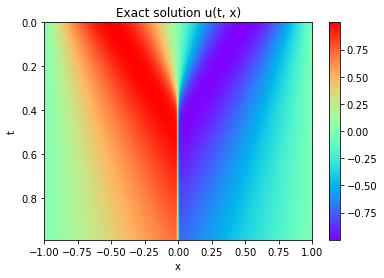

In [136]:
# imshow taking origin at top-left, that is, row-0, col-0 is at top-left.
# In imshow extent=(left, right, bottom, top)
plt.imshow(Exact, extent=(X.min(), X.max(), T.max(), T.min()), aspect='auto', cmap='rainbow')
plt.title("Exact solution u(t, x)")
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

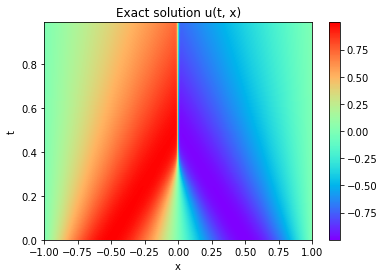

In [137]:
# We can also plot it with origin at bottom left,
# that is, row-0, col-0 is at bottom left
plt.imshow(Exact, extent=(X.min(), X.max(), T.min(), T.max()),
           aspect='auto', cmap='rainbow', origin="lower")
plt.title("Exact solution u(t, x)")
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

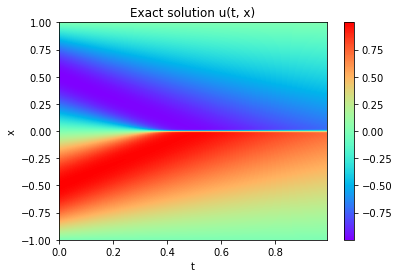

In [138]:
# We can also plot it like fig 1 in the paper
# Now x-axis is time and y-axis is `x`
# and origin is at the bottom-left
plt.imshow(Exact.T, extent=(T.min(), T.max(), X.min(), X.max()),
          cmap="rainbow", aspect="auto", origin="lower")
plt.title("Exact solution u(t, x)")
plt.xlabel('t')
plt.ylabel('x')
plt.colorbar()
plt.show()

Let'plot the bottom row of fig 1 also --- only the exact solution.

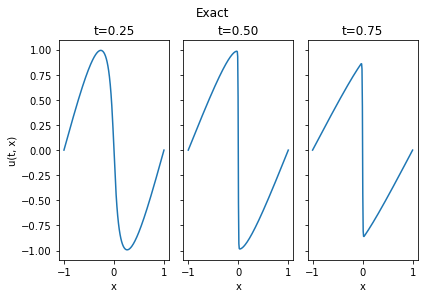

In [139]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.plot(X[24], Exact[24])
ax1.set_xlabel("x")
ax1.set_ylabel("u(t, x)")
ax1.set_title("t=0.25")

ax2.plot(X[49], Exact[49])
ax2.set_xlabel("x")
ax2.set_title("t=0.50")

ax3.plot(X[74], Exact[74])
ax3.set_xlabel("x")
ax3.set_title("t=0.75")

plt.tight_layout()
plt.suptitle("Exact", va="bottom")
plt.show()

# Training points

## Initial and boundary condition points

We'll use top row of figure 1 in the paper to name our boundaries. Top is x=1 and bottom is x=-1. 

In [140]:
# Top boundary. X=1, T=0 to 1
X_top = X[:, -1:]  
T_top = T[:, -1:]
Exact_top = Exact[:, -1:]
# Bottom boundary. X=-1, T=0 to 1
X_bottom = X[:, :1]  
T_bottom = T[:, :1]
Exact_bottom = Exact[:, :1]
# Initial condition T=0, X=-1 to 1
X_init = X[:1, :]
T_init = T[:1, :]
Exact_init = Exact[:1, :]

In [141]:
# Top boundary X=1
# `X_top` and `T_top` are already column vectors
top_coords = np.hstack((X_top, T_top))
# Bottom boundary. X=-1
# `X_bottom` and `T_bottom` are already column vectors
bottom_coords = np.hstack((X_bottom, T_bottom))
# Init condition
# `X_init` and `T_init` are row vectors. Need to convert to column vecs
init_coords = np.hstack((X_init.T, T_init.T))

In [142]:
top_coords.shape, bottom_coords.shape, init_coords.shape

((100, 2), (100, 2), (256, 2))

In [143]:
IC_BC_coords = np.vstack((top_coords, init_coords, bottom_coords))

In [144]:
IC_BC_coords.shape

(456, 2)

In [145]:
IC_BC_u = np.vstack((Exact_top, Exact_init.T, Exact_bottom))

In [146]:
IC_BC_u.shape

(456, 1)

In [147]:
# Let's randomly select `N_u` points for training purpose
idx = rng.choice(len(IC_BC_u), size=N_u, replace=True, shuffle=False)

In [148]:
X_u_train = IC_BC_coords[idx]
u_train = IC_BC_u[idx]

In [149]:
X_u_train.shape, u_train.shape

((100, 2), (100, 1))

Let's plot training points like the top row of figure 1 in the paper.

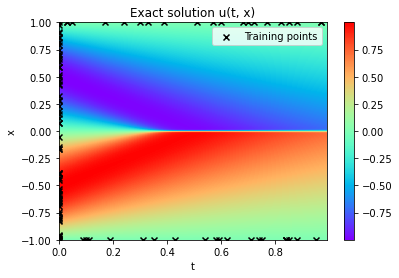

In [150]:
plt.imshow(Exact.T, extent=(T.min(), T.max(), X.min(), X.max()),
          cmap="rainbow", aspect="auto", origin="lower")
plt.colorbar()
plt.scatter(X_u_train[:, 1], X_u_train[:, 0], marker='x', color='k',
            label="Training points")
plt.title("Exact solution u(t, x)")
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

## Collocation points for f(t, x)

In [151]:
# Sample (t, x) in the domain using Latin hypercube sampling (LHS)
# Dimension of the parameter space is 2: (t, x)
sampler = qmc.LatinHypercube(d=2)
X_f = sampler.random(n=N_f)
# Original samples are in range [0, 1).
# Scale them to desired lower and upper bounds
X_f = qmc.scale(X_f, l_bounds=(X.min(), T.min()),
                u_bounds=(X.max(), T.max()))

In [152]:
# Evaluate f(t, x) on the boundary points also
X_f_train = np.vstack((X_f, X_u_train))

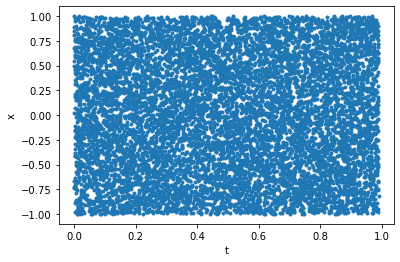

In [153]:
# Plot the collocation points
# Note: X_f_train includes X_u_train. Only X_f plotted here
plt.scatter(X_f[:, 1], X_f[:, 0], marker=".")  
plt.xlabel('t')
plt.ylabel('x')
plt.show()

# Model architecture

In [154]:
num_hidden_layers = 8
activation = "tanh"
units = 20

In [155]:
model = keras.Sequential([])
model.add(keras.Input(2, ))  # Input layer of shape (2, )
for _ in range(num_hidden_layers):  # Add hidden layers
    model.add(layers.Dense(units, activation=activation))
model.add(layers.Dense(units=1))  # Add the output layer

In [156]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 20)                60        
                                                                 
 dense_20 (Dense)            (None, 20)                420       
                                                                 
 dense_21 (Dense)            (None, 20)                420       
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 20)                420       
                                                                 
 dense_24 (Dense)            (None, 20)                420       
                                                                 
 dense_25 (Dense)            (None, 20)               

In [221]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Custom loss

In [173]:
x_tf = tf.constant(X_f_train[:, 0:1].astype("float32"))
t_tf = tf.constant(X_f_train[:, 1:].astype("float32"))

In [174]:
x_tf

<tf.Tensor: shape=(10100, 1), dtype=float32, numpy=
array([[ 0.9675976 ],
       [ 0.43849525],
       [-0.56135666],
       ...,
       [ 0.8980392 ],
       [ 0.81960785],
       [ 1.        ]], dtype=float32)>

In [175]:
t_tf

<tf.Tensor: shape=(10100, 1), dtype=float32, numpy=
array([[0.5034882 ],
       [0.8289438 ],
       [0.36897156],
       ...,
       [0.        ],
       [0.        ],
       [0.3       ]], dtype=float32)>

In [177]:
def custom_loss(y_true, y_pred):
    MSE_u = keras.losses.mean_squared_error(y_true, y_pred)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_tf)
        tape.watch(t_tf)
        u = model(tf.concat([x_tf, t_tf], axis=1))
        du_dx = tape.gradient(u, x_tf)
    du_dt = tape.gradient(u, t_tf)
    d2u_dx2 = tape.gradient(du_dx, x_tf)
    del tape
    f = du_dt + u*du_dx - (ν/π)*d2u_dx2  # Burgers' equation
    MSE_f = tf.reduce_mean(tf.square(f))
    
    return MSE_u + MSE_f

# Training

In [222]:
epochs = 5000

In [195]:
model.compile(loss=custom_loss,
             optimizer="adam",
             metrics=["mae"])

In [196]:
history = model.fit(X_u_train,
                    u_train,
                    validation_split=0.2,
                    epochs=epochs)

Epoch 1/5000
3/3 [==============================] - 1s 114ms/step - loss: 0.1633 - mae: 0.3196 - val_loss: 0.1377 - val_mae: 0.2897
Epoch 2/5000
3/3 [==============================] - 0s 27ms/step - loss: 0.1627 - mae: 0.2897 - val_loss: 0.1259 - val_mae: 0.2736
Epoch 3/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.1500 - mae: 0.3025 - val_loss: 0.1190 - val_mae: 0.2606
Epoch 4/5000
3/3 [==============================] - 0s 28ms/step - loss: 0.1556 - mae: 0.3093 - val_loss: 0.1201 - val_mae: 0.2687
Epoch 5/5000
3/3 [==============================] - 0s 29ms/step - loss: 0.1520 - mae: 0.2907 - val_loss: 0.1273 - val_mae: 0.2717
Epoch 6/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.1528 - mae: 0.2928 - val_loss: 0.1190 - val_mae: 0.2591
Epoch 7/5000
3/3 [==============================] - 0s 29ms/step - loss: 0.1492 - mae: 0.2892 - val_loss: 0.1207 - val_mae: 0.2626
Epoch 8/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.1436 - 

3/3 [==============================] - 0s 36ms/step - loss: 0.1118 - mae: 0.2133 - val_loss: 0.0951 - val_mae: 0.1958
Epoch 64/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.1121 - mae: 0.2123 - val_loss: 0.0955 - val_mae: 0.2064
Epoch 65/5000
3/3 [==============================] - 0s 41ms/step - loss: 0.1197 - mae: 0.2191 - val_loss: 0.0920 - val_mae: 0.1995
Epoch 66/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.1128 - mae: 0.2154 - val_loss: 0.0967 - val_mae: 0.1978
Epoch 67/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.1140 - mae: 0.2180 - val_loss: 0.0909 - val_mae: 0.2019
Epoch 68/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.1142 - mae: 0.2210 - val_loss: 0.0891 - val_mae: 0.1937
Epoch 69/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.1105 - mae: 0.2172 - val_loss: 0.0962 - val_mae: 0.2029
Epoch 70/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.1106 - mae: 0.

Epoch 125/5000
3/3 [==============================] - 0s 29ms/step - loss: 0.0904 - mae: 0.1964 - val_loss: 0.0754 - val_mae: 0.1801
Epoch 126/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0901 - mae: 0.1973 - val_loss: 0.0755 - val_mae: 0.1806
Epoch 127/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0877 - mae: 0.1920 - val_loss: 0.0779 - val_mae: 0.1919
Epoch 128/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0896 - mae: 0.1932 - val_loss: 0.0742 - val_mae: 0.1787
Epoch 129/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0882 - mae: 0.1961 - val_loss: 0.0761 - val_mae: 0.1815
Epoch 130/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0875 - mae: 0.1919 - val_loss: 0.0741 - val_mae: 0.1778
Epoch 131/5000
3/3 [==============================] - 0s 41ms/step - loss: 0.0881 - mae: 0.1918 - val_loss: 0.0748 - val_mae: 0.1774
Epoch 132/5000
3/3 [==============================] - 0s 35ms/step - 

3/3 [==============================] - 0s 41ms/step - loss: 0.0744 - mae: 0.1793 - val_loss: 0.0672 - val_mae: 0.1753
Epoch 187/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0735 - mae: 0.1753 - val_loss: 0.0689 - val_mae: 0.1764
Epoch 188/5000
3/3 [==============================] - 0s 41ms/step - loss: 0.0733 - mae: 0.1719 - val_loss: 0.0693 - val_mae: 0.1746
Epoch 189/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0733 - mae: 0.1706 - val_loss: 0.0692 - val_mae: 0.1737
Epoch 190/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0738 - mae: 0.1727 - val_loss: 0.0704 - val_mae: 0.1757
Epoch 191/5000
3/3 [==============================] - 0s 29ms/step - loss: 0.0731 - mae: 0.1703 - val_loss: 0.0702 - val_mae: 0.1744
Epoch 192/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0741 - mae: 0.1726 - val_loss: 0.0717 - val_mae: 0.1739
Epoch 193/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0744 - 

Epoch 248/5000
3/3 [==============================] - 0s 28ms/step - loss: 0.0667 - mae: 0.1705 - val_loss: 0.0593 - val_mae: 0.1618
Epoch 249/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0661 - mae: 0.1629 - val_loss: 0.0638 - val_mae: 0.1630
Epoch 250/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0669 - mae: 0.1561 - val_loss: 0.0624 - val_mae: 0.1583
Epoch 251/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0660 - mae: 0.1559 - val_loss: 0.0610 - val_mae: 0.1609
Epoch 252/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0647 - mae: 0.1570 - val_loss: 0.0590 - val_mae: 0.1621
Epoch 253/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0651 - mae: 0.1639 - val_loss: 0.0582 - val_mae: 0.1638
Epoch 254/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0659 - mae: 0.1754 - val_loss: 0.0580 - val_mae: 0.1612
Epoch 255/5000
3/3 [==============================] - 0s 36ms/step - 

3/3 [==============================] - 0s 33ms/step - loss: 0.0605 - mae: 0.1556 - val_loss: 0.0543 - val_mae: 0.1495
Epoch 310/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0595 - mae: 0.1505 - val_loss: 0.0562 - val_mae: 0.1548
Epoch 311/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0601 - mae: 0.1502 - val_loss: 0.0541 - val_mae: 0.1509
Epoch 312/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0611 - mae: 0.1605 - val_loss: 0.0551 - val_mae: 0.1482
Epoch 313/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0595 - mae: 0.1460 - val_loss: 0.0593 - val_mae: 0.1583
Epoch 314/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0597 - mae: 0.1450 - val_loss: 0.0561 - val_mae: 0.1500
Epoch 315/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0613 - mae: 0.1610 - val_loss: 0.0535 - val_mae: 0.1506
Epoch 316/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0601 - 

Epoch 371/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0566 - mae: 0.1446 - val_loss: 0.0494 - val_mae: 0.1430
Epoch 372/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0562 - mae: 0.1538 - val_loss: 0.0506 - val_mae: 0.1419
Epoch 373/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0555 - mae: 0.1396 - val_loss: 0.0517 - val_mae: 0.1464
Epoch 374/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0548 - mae: 0.1393 - val_loss: 0.0494 - val_mae: 0.1421
Epoch 375/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0552 - mae: 0.1470 - val_loss: 0.0493 - val_mae: 0.1418
Epoch 376/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0547 - mae: 0.1391 - val_loss: 0.0490 - val_mae: 0.1384
Epoch 377/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0543 - mae: 0.1409 - val_loss: 0.0499 - val_mae: 0.1367
Epoch 378/5000
3/3 [==============================] - 0s 30ms/step - 

3/3 [==============================] - 0s 31ms/step - loss: 0.0509 - mae: 0.1311 - val_loss: 0.0492 - val_mae: 0.1329
Epoch 433/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0518 - mae: 0.1282 - val_loss: 0.0489 - val_mae: 0.1364
Epoch 434/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0509 - mae: 0.1271 - val_loss: 0.0479 - val_mae: 0.1360
Epoch 435/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0506 - mae: 0.1367 - val_loss: 0.0478 - val_mae: 0.1388
Epoch 436/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0509 - mae: 0.1311 - val_loss: 0.0470 - val_mae: 0.1376
Epoch 437/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0510 - mae: 0.1389 - val_loss: 0.0466 - val_mae: 0.1354
Epoch 438/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0505 - mae: 0.1306 - val_loss: 0.0485 - val_mae: 0.1402
Epoch 439/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0508 - 

Epoch 494/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0474 - mae: 0.1292 - val_loss: 0.0455 - val_mae: 0.1327
Epoch 495/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0469 - mae: 0.1247 - val_loss: 0.0451 - val_mae: 0.1311
Epoch 496/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0467 - mae: 0.1230 - val_loss: 0.0479 - val_mae: 0.1334
Epoch 497/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0471 - mae: 0.1211 - val_loss: 0.0449 - val_mae: 0.1304
Epoch 498/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.0465 - mae: 0.1293 - val_loss: 0.0445 - val_mae: 0.1327
Epoch 499/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0462 - mae: 0.1243 - val_loss: 0.0437 - val_mae: 0.1299
Epoch 500/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0461 - mae: 0.1263 - val_loss: 0.0441 - val_mae: 0.1282
Epoch 501/5000
3/3 [==============================] - 0s 40ms/step - 

3/3 [==============================] - 0s 30ms/step - loss: 0.0418 - mae: 0.1148 - val_loss: 0.0395 - val_mae: 0.1239
Epoch 556/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0406 - mae: 0.1187 - val_loss: 0.0399 - val_mae: 0.1219
Epoch 557/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0402 - mae: 0.1162 - val_loss: 0.0385 - val_mae: 0.1212
Epoch 558/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0404 - mae: 0.1130 - val_loss: 0.0381 - val_mae: 0.1208
Epoch 559/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0400 - mae: 0.1170 - val_loss: 0.0387 - val_mae: 0.1200
Epoch 560/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0396 - mae: 0.1153 - val_loss: 0.0378 - val_mae: 0.1181
Epoch 561/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0416 - mae: 0.1154 - val_loss: 0.0377 - val_mae: 0.1200
Epoch 562/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0400 - 

Epoch 617/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0329 - mae: 0.1076 - val_loss: 0.0315 - val_mae: 0.1100
Epoch 618/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0329 - mae: 0.1088 - val_loss: 0.0307 - val_mae: 0.1079
Epoch 619/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0328 - mae: 0.1053 - val_loss: 0.0311 - val_mae: 0.1040
Epoch 620/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0324 - mae: 0.0963 - val_loss: 0.0318 - val_mae: 0.1068
Epoch 621/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0320 - mae: 0.0966 - val_loss: 0.0307 - val_mae: 0.1069
Epoch 622/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0319 - mae: 0.1031 - val_loss: 0.0311 - val_mae: 0.1075
Epoch 623/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0322 - mae: 0.1011 - val_loss: 0.0302 - val_mae: 0.1076
Epoch 624/5000
3/3 [==============================] - 0s 37ms/step - 

3/3 [==============================] - 0s 33ms/step - loss: 0.0237 - mae: 0.0816 - val_loss: 0.0215 - val_mae: 0.0851
Epoch 679/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0232 - mae: 0.0879 - val_loss: 0.0233 - val_mae: 0.0836
Epoch 680/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0266 - mae: 0.0808 - val_loss: 0.0234 - val_mae: 0.0867
Epoch 681/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0286 - mae: 0.0829 - val_loss: 0.0259 - val_mae: 0.0848
Epoch 682/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0300 - mae: 0.0851 - val_loss: 0.0305 - val_mae: 0.0860
Epoch 683/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0280 - mae: 0.0851 - val_loss: 0.0290 - val_mae: 0.0840
Epoch 684/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.0270 - mae: 0.0820 - val_loss: 0.0220 - val_mae: 0.0882
Epoch 685/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0264 - 

Epoch 740/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0189 - mae: 0.0767 - val_loss: 0.0156 - val_mae: 0.0724
Epoch 741/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.0185 - mae: 0.0714 - val_loss: 0.0153 - val_mae: 0.0712
Epoch 742/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0181 - mae: 0.0719 - val_loss: 0.0150 - val_mae: 0.0693
Epoch 743/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0179 - mae: 0.0704 - val_loss: 0.0155 - val_mae: 0.0712
Epoch 744/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0178 - mae: 0.0675 - val_loss: 0.0147 - val_mae: 0.0677
Epoch 745/5000
3/3 [==============================] - 0s 28ms/step - loss: 0.0177 - mae: 0.0709 - val_loss: 0.0148 - val_mae: 0.0692
Epoch 746/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0175 - mae: 0.0684 - val_loss: 0.0144 - val_mae: 0.0680
Epoch 747/5000
3/3 [==============================] - 0s 40ms/step - 

3/3 [==============================] - 0s 37ms/step - loss: 0.0100 - mae: 0.0479 - val_loss: 0.0076 - val_mae: 0.0395
Epoch 802/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0099 - mae: 0.0479 - val_loss: 0.0074 - val_mae: 0.0378
Epoch 803/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0098 - mae: 0.0462 - val_loss: 0.0074 - val_mae: 0.0379
Epoch 804/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0099 - mae: 0.0461 - val_loss: 0.0077 - val_mae: 0.0383
Epoch 805/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0097 - mae: 0.0460 - val_loss: 0.0074 - val_mae: 0.0368
Epoch 806/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0098 - mae: 0.0456 - val_loss: 0.0073 - val_mae: 0.0376
Epoch 807/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0095 - mae: 0.0455 - val_loss: 0.0076 - val_mae: 0.0378
Epoch 808/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0095 - 

Epoch 863/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0079 - mae: 0.0365 - val_loss: 0.0095 - val_mae: 0.0266
Epoch 864/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0092 - mae: 0.0361 - val_loss: 0.0059 - val_mae: 0.0294
Epoch 865/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0078 - mae: 0.0371 - val_loss: 0.0049 - val_mae: 0.0320
Epoch 866/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0071 - mae: 0.0368 - val_loss: 0.0050 - val_mae: 0.0265
Epoch 867/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0070 - mae: 0.0392 - val_loss: 0.0049 - val_mae: 0.0284
Epoch 868/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0066 - mae: 0.0380 - val_loss: 0.0051 - val_mae: 0.0284
Epoch 869/5000
3/3 [==============================] - 0s 41ms/step - loss: 0.0065 - mae: 0.0348 - val_loss: 0.0051 - val_mae: 0.0280
Epoch 870/5000
3/3 [==============================] - 0s 33ms/step - 

3/3 [==============================] - 0s 37ms/step - loss: 0.0072 - mae: 0.0286 - val_loss: 0.0054 - val_mae: 0.0246
Epoch 925/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0060 - mae: 0.0295 - val_loss: 0.0041 - val_mae: 0.0239
Epoch 926/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0048 - mae: 0.0278 - val_loss: 0.0035 - val_mae: 0.0263
Epoch 927/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0044 - mae: 0.0269 - val_loss: 0.0043 - val_mae: 0.0251
Epoch 928/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0053 - mae: 0.0290 - val_loss: 0.0041 - val_mae: 0.0248
Epoch 929/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0048 - mae: 0.0286 - val_loss: 0.0034 - val_mae: 0.0258
Epoch 930/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0042 - mae: 0.0278 - val_loss: 0.0037 - val_mae: 0.0255
Epoch 931/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0046 - 

Epoch 986/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0031 - mae: 0.0259 - val_loss: 0.0029 - val_mae: 0.0281
Epoch 987/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.0261 - val_loss: 0.0028 - val_mae: 0.0288
Epoch 988/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0031 - mae: 0.0253 - val_loss: 0.0030 - val_mae: 0.0300
Epoch 989/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.0030 - mae: 0.0233 - val_loss: 0.0029 - val_mae: 0.0283
Epoch 990/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.0249 - val_loss: 0.0029 - val_mae: 0.0285
Epoch 991/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0030 - mae: 0.0249 - val_loss: 0.0029 - val_mae: 0.0289
Epoch 992/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0030 - mae: 0.0234 - val_loss: 0.0029 - val_mae: 0.0289
Epoch 993/5000
3/3 [==============================] - 0s 36ms/step - 

3/3 [==============================] - 0s 29ms/step - loss: 0.0023 - mae: 0.0200 - val_loss: 0.0023 - val_mae: 0.0245
Epoch 1048/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0023 - mae: 0.0201 - val_loss: 0.0023 - val_mae: 0.0245
Epoch 1049/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.0199 - val_loss: 0.0023 - val_mae: 0.0249
Epoch 1050/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0023 - mae: 0.0202 - val_loss: 0.0023 - val_mae: 0.0252
Epoch 1051/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0023 - mae: 0.0198 - val_loss: 0.0023 - val_mae: 0.0251
Epoch 1052/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0023 - mae: 0.0200 - val_loss: 0.0023 - val_mae: 0.0250
Epoch 1053/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0023 - mae: 0.0205 - val_loss: 0.0022 - val_mae: 0.0240
Epoch 1054/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.

3/3 [==============================] - 0s 34ms/step - loss: 0.0019 - mae: 0.0175 - val_loss: 0.0019 - val_mae: 0.0217
Epoch 1109/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0019 - mae: 0.0193 - val_loss: 0.0020 - val_mae: 0.0229
Epoch 1110/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.0174 - val_loss: 0.0019 - val_mae: 0.0226
Epoch 1111/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0019 - mae: 0.0176 - val_loss: 0.0019 - val_mae: 0.0216
Epoch 1112/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.0185 - val_loss: 0.0019 - val_mae: 0.0232
Epoch 1113/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0019 - mae: 0.0172 - val_loss: 0.0019 - val_mae: 0.0228
Epoch 1114/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0019 - mae: 0.0179 - val_loss: 0.0019 - val_mae: 0.0226
Epoch 1115/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.

3/3 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.0176 - val_loss: 0.0042 - val_mae: 0.0226
Epoch 1170/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0046 - mae: 0.0164 - val_loss: 0.0048 - val_mae: 0.0212
Epoch 1171/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0035 - mae: 0.0181 - val_loss: 0.0022 - val_mae: 0.0190
Epoch 1172/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.0179 - val_loss: 0.0027 - val_mae: 0.0230
Epoch 1173/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.0159 - val_loss: 0.0022 - val_mae: 0.0239
Epoch 1174/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0024 - mae: 0.0174 - val_loss: 0.0028 - val_mae: 0.0202
Epoch 1175/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.0025 - mae: 0.0186 - val_loss: 0.0016 - val_mae: 0.0214
Epoch 1176/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.

3/3 [==============================] - 0s 33ms/step - loss: 0.0022 - mae: 0.0165 - val_loss: 0.0016 - val_mae: 0.0215
Epoch 1231/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0016 - mae: 0.0154 - val_loss: 0.0019 - val_mae: 0.0199
Epoch 1232/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0018 - mae: 0.0163 - val_loss: 0.0015 - val_mae: 0.0196
Epoch 1233/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0167 - val_loss: 0.0017 - val_mae: 0.0203
Epoch 1234/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0018 - mae: 0.0160 - val_loss: 0.0018 - val_mae: 0.0212
Epoch 1235/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0148 - val_loss: 0.0015 - val_mae: 0.0192
Epoch 1236/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0015 - mae: 0.0156 - val_loss: 0.0016 - val_mae: 0.0194
Epoch 1237/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.

3/3 [==============================] - 0s 33ms/step - loss: 0.0044 - mae: 0.0311 - val_loss: 0.0052 - val_mae: 0.0410
Epoch 1292/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0040 - mae: 0.0306 - val_loss: 0.0048 - val_mae: 0.0401
Epoch 1293/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0037 - mae: 0.0274 - val_loss: 0.0043 - val_mae: 0.0356
Epoch 1294/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.0285 - val_loss: 0.0041 - val_mae: 0.0360
Epoch 1295/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0032 - mae: 0.0260 - val_loss: 0.0037 - val_mae: 0.0343
Epoch 1296/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0030 - mae: 0.0270 - val_loss: 0.0036 - val_mae: 0.0357
Epoch 1297/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.0255 - val_loss: 0.0034 - val_mae: 0.0338
Epoch 1298/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.

3/3 [==============================] - 0s 33ms/step - loss: 0.0013 - mae: 0.0149 - val_loss: 0.0019 - val_mae: 0.0243
Epoch 1353/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0013 - mae: 0.0162 - val_loss: 0.0020 - val_mae: 0.0253
Epoch 1354/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0153 - val_loss: 0.0020 - val_mae: 0.0252
Epoch 1355/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0152 - val_loss: 0.0019 - val_mae: 0.0244
Epoch 1356/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0155 - val_loss: 0.0019 - val_mae: 0.0249
Epoch 1357/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0013 - mae: 0.0153 - val_loss: 0.0019 - val_mae: 0.0247
Epoch 1358/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0013 - mae: 0.0153 - val_loss: 0.0019 - val_mae: 0.0249
Epoch 1359/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.

3/3 [==============================] - 0s 31ms/step - loss: 0.0012 - mae: 0.0140 - val_loss: 0.0018 - val_mae: 0.0231
Epoch 1414/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0011 - mae: 0.0143 - val_loss: 0.0018 - val_mae: 0.0234
Epoch 1415/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0011 - mae: 0.0143 - val_loss: 0.0018 - val_mae: 0.0235
Epoch 1416/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0143 - val_loss: 0.0017 - val_mae: 0.0227
Epoch 1417/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.0011 - mae: 0.0142 - val_loss: 0.0018 - val_mae: 0.0226
Epoch 1418/5000
3/3 [==============================] - 0s 29ms/step - loss: 0.0011 - mae: 0.0145 - val_loss: 0.0017 - val_mae: 0.0226
Epoch 1419/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0011 - mae: 0.0148 - val_loss: 0.0017 - val_mae: 0.0230
Epoch 1420/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.

3/3 [==============================] - 0s 34ms/step - loss: 0.0015 - mae: 0.0138 - val_loss: 0.0021 - val_mae: 0.0226
Epoch 1475/5000
3/3 [==============================] - 0s 42ms/step - loss: 0.0014 - mae: 0.0132 - val_loss: 0.0018 - val_mae: 0.0212
Epoch 1476/5000
3/3 [==============================] - 0s 29ms/step - loss: 0.0011 - mae: 0.0134 - val_loss: 0.0016 - val_mae: 0.0217
Epoch 1477/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0011 - mae: 0.0136 - val_loss: 0.0019 - val_mae: 0.0224
Epoch 1478/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0014 - mae: 0.0134 - val_loss: 0.0025 - val_mae: 0.0212
Epoch 1479/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0022 - mae: 0.0132 - val_loss: 0.0035 - val_mae: 0.0232
Epoch 1480/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0030 - mae: 0.0144 - val_loss: 0.0033 - val_mae: 0.0218
Epoch 1481/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.

3/3 [==============================] - 0s 30ms/step - loss: 0.0013 - mae: 0.0133 - val_loss: 0.0023 - val_mae: 0.0213
Epoch 1536/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.0132 - val_loss: 0.0019 - val_mae: 0.0222
Epoch 1537/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0011 - mae: 0.0138 - val_loss: 0.0016 - val_mae: 0.0214
Epoch 1538/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0012 - mae: 0.0127 - val_loss: 0.0021 - val_mae: 0.0200
Epoch 1539/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0018 - mae: 0.0131 - val_loss: 0.0027 - val_mae: 0.0224
Epoch 1540/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.0138 - val_loss: 0.0023 - val_mae: 0.0220
Epoch 1541/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0015 - mae: 0.0137 - val_loss: 0.0016 - val_mae: 0.0219
Epoch 1542/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.

Epoch 1596/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0010 - mae: 0.0132 - val_loss: 0.0015 - val_mae: 0.0210
Epoch 1597/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0011 - mae: 0.0123 - val_loss: 0.0018 - val_mae: 0.0209
Epoch 1598/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0014 - mae: 0.0127 - val_loss: 0.0024 - val_mae: 0.0203
Epoch 1599/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.0020 - mae: 0.0126 - val_loss: 0.0030 - val_mae: 0.0225
Epoch 1600/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.0127 - val_loss: 0.0022 - val_mae: 0.0195
Epoch 1601/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0014 - mae: 0.0135 - val_loss: 0.0015 - val_mae: 0.0208
Epoch 1602/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0011 - mae: 0.0125 - val_loss: 0.0020 - val_mae: 0.0215
Epoch 1603/5000
3/3 [==============================] - 0s 39ms

3/3 [==============================] - 0s 37ms/step - loss: 7.8959e-04 - mae: 0.0107 - val_loss: 0.0011 - val_mae: 0.0167
Epoch 1657/5000
3/3 [==============================] - 0s 33ms/step - loss: 7.6470e-04 - mae: 0.0099 - val_loss: 0.0011 - val_mae: 0.0168
Epoch 1658/5000
3/3 [==============================] - 0s 35ms/step - loss: 7.5602e-04 - mae: 0.0102 - val_loss: 0.0010 - val_mae: 0.0163
Epoch 1659/5000
3/3 [==============================] - 0s 38ms/step - loss: 7.4037e-04 - mae: 0.0104 - val_loss: 0.0011 - val_mae: 0.0171
Epoch 1660/5000
3/3 [==============================] - 0s 34ms/step - loss: 7.4507e-04 - mae: 0.0100 - val_loss: 0.0011 - val_mae: 0.0168
Epoch 1661/5000
3/3 [==============================] - 0s 36ms/step - loss: 7.3705e-04 - mae: 0.0105 - val_loss: 0.0011 - val_mae: 0.0166
Epoch 1662/5000
3/3 [==============================] - 0s 38ms/step - loss: 7.3691e-04 - mae: 0.0101 - val_loss: 0.0011 - val_mae: 0.0165
Epoch 1663/5000
3/3 [=============================

3/3 [==============================] - 0s 30ms/step - loss: 6.9882e-04 - mae: 0.0108 - val_loss: 0.0010 - val_mae: 0.0159
Epoch 1716/5000
3/3 [==============================] - 0s 35ms/step - loss: 6.9784e-04 - mae: 0.0096 - val_loss: 0.0011 - val_mae: 0.0166
Epoch 1717/5000
3/3 [==============================] - 0s 35ms/step - loss: 7.6792e-04 - mae: 0.0104 - val_loss: 0.0012 - val_mae: 0.0159
Epoch 1718/5000
3/3 [==============================] - 0s 29ms/step - loss: 9.5910e-04 - mae: 0.0103 - val_loss: 0.0016 - val_mae: 0.0175
Epoch 1719/5000
3/3 [==============================] - 0s 41ms/step - loss: 0.0013 - mae: 0.0100 - val_loss: 0.0017 - val_mae: 0.0145
Epoch 1720/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0100 - val_loss: 0.0013 - val_mae: 0.0168
Epoch 1721/5000
3/3 [==============================] - 0s 32ms/step - loss: 7.8977e-04 - mae: 0.0094 - val_loss: 0.0011 - val_mae: 0.0162
Epoch 1722/5000
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 33ms/step - loss: 7.2247e-04 - mae: 0.0094 - val_loss: 9.4329e-04 - val_mae: 0.0160
Epoch 1775/5000
3/3 [==============================] - 0s 39ms/step - loss: 6.5262e-04 - mae: 0.0097 - val_loss: 0.0012 - val_mae: 0.0169
Epoch 1776/5000
3/3 [==============================] - 0s 40ms/step - loss: 8.3922e-04 - mae: 0.0092 - val_loss: 0.0012 - val_mae: 0.0156
Epoch 1777/5000
3/3 [==============================] - 0s 40ms/step - loss: 9.7837e-04 - mae: 0.0100 - val_loss: 0.0014 - val_mae: 0.0165
Epoch 1778/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0011 - mae: 0.0096 - val_loss: 0.0013 - val_mae: 0.0148
Epoch 1779/5000
3/3 [==============================] - 0s 36ms/step - loss: 9.7085e-04 - mae: 0.0096 - val_loss: 0.0012 - val_mae: 0.0157
Epoch 1780/5000
3/3 [==============================] - 0s 39ms/step - loss: 8.3849e-04 - mae: 0.0094 - val_loss: 9.9779e-04 - val_mae: 0.0143
Epoch 1781/5000
3/3 [=========================

3/3 [==============================] - 0s 31ms/step - loss: 9.7129e-04 - mae: 0.0090 - val_loss: 0.0012 - val_mae: 0.0162
Epoch 1834/5000
3/3 [==============================] - 0s 39ms/step - loss: 8.5435e-04 - mae: 0.0093 - val_loss: 9.7864e-04 - val_mae: 0.0141
Epoch 1835/5000
3/3 [==============================] - 0s 39ms/step - loss: 7.2121e-04 - mae: 0.0097 - val_loss: 9.1968e-04 - val_mae: 0.0150
Epoch 1836/5000
3/3 [==============================] - 0s 32ms/step - loss: 6.0287e-04 - mae: 0.0088 - val_loss: 8.9795e-04 - val_mae: 0.0144
Epoch 1837/5000
3/3 [==============================] - 0s 40ms/step - loss: 6.3847e-04 - mae: 0.0097 - val_loss: 9.5558e-04 - val_mae: 0.0145
Epoch 1838/5000
3/3 [==============================] - 0s 32ms/step - loss: 7.2060e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0159
Epoch 1839/5000
3/3 [==============================] - 0s 41ms/step - loss: 8.1513e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0150
Epoch 1840/5000
3/3 [=============

3/3 [==============================] - 0s 33ms/step - loss: 5.8685e-04 - mae: 0.0090 - val_loss: 8.5618e-04 - val_mae: 0.0132
Epoch 1893/5000
3/3 [==============================] - 0s 39ms/step - loss: 6.5671e-04 - mae: 0.0103 - val_loss: 9.8353e-04 - val_mae: 0.0144
Epoch 1894/5000
3/3 [==============================] - 0s 34ms/step - loss: 7.4001e-04 - mae: 0.0084 - val_loss: 9.9988e-04 - val_mae: 0.0138
Epoch 1895/5000
3/3 [==============================] - 0s 39ms/step - loss: 7.4562e-04 - mae: 0.0088 - val_loss: 9.6015e-04 - val_mae: 0.0145
Epoch 1896/5000
3/3 [==============================] - 0s 37ms/step - loss: 6.3333e-04 - mae: 0.0086 - val_loss: 8.0737e-04 - val_mae: 0.0139
Epoch 1897/5000
3/3 [==============================] - 0s 30ms/step - loss: 5.3670e-04 - mae: 0.0086 - val_loss: 7.9073e-04 - val_mae: 0.0134
Epoch 1898/5000
3/3 [==============================] - 0s 33ms/step - loss: 5.5535e-04 - mae: 0.0086 - val_loss: 8.9388e-04 - val_mae: 0.0141
Epoch 1899/5000
3/3 [=

Epoch 1951/5000
3/3 [==============================] - 0s 29ms/step - loss: 5.4360e-04 - mae: 0.0090 - val_loss: 9.0415e-04 - val_mae: 0.0150
Epoch 1952/5000
3/3 [==============================] - 0s 38ms/step - loss: 6.3287e-04 - mae: 0.0081 - val_loss: 9.3433e-04 - val_mae: 0.0148
Epoch 1953/5000
3/3 [==============================] - 0s 36ms/step - loss: 6.7678e-04 - mae: 0.0092 - val_loss: 9.7390e-04 - val_mae: 0.0138
Epoch 1954/5000
3/3 [==============================] - 0s 35ms/step - loss: 7.9527e-04 - mae: 0.0082 - val_loss: 0.0013 - val_mae: 0.0146
Epoch 1955/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0081 - val_loss: 0.0013 - val_mae: 0.0124
Epoch 1956/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0012 - mae: 0.0094 - val_loss: 0.0014 - val_mae: 0.0147
Epoch 1957/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0010 - mae: 0.0083 - val_loss: 0.0010 - val_mae: 0.0125
Epoch 1958/5000
3/3 [=============

Epoch 2010/5000
3/3 [==============================] - 0s 32ms/step - loss: 5.5937e-04 - mae: 0.0095 - val_loss: 7.6271e-04 - val_mae: 0.0135
Epoch 2011/5000
3/3 [==============================] - 0s 33ms/step - loss: 5.6033e-04 - mae: 0.0080 - val_loss: 8.4589e-04 - val_mae: 0.0142
Epoch 2012/5000
3/3 [==============================] - 0s 42ms/step - loss: 6.3916e-04 - mae: 0.0086 - val_loss: 8.4571e-04 - val_mae: 0.0146
Epoch 2013/5000
3/3 [==============================] - 0s 33ms/step - loss: 5.8474e-04 - mae: 0.0083 - val_loss: 7.5661e-04 - val_mae: 0.0142
Epoch 2014/5000
3/3 [==============================] - 0s 35ms/step - loss: 5.2149e-04 - mae: 0.0088 - val_loss: 9.0029e-04 - val_mae: 0.0142
Epoch 2015/5000
3/3 [==============================] - 0s 37ms/step - loss: 6.3248e-04 - mae: 0.0077 - val_loss: 8.3268e-04 - val_mae: 0.0128
Epoch 2016/5000
3/3 [==============================] - 0s 37ms/step - loss: 5.6632e-04 - mae: 0.0085 - val_loss: 7.6078e-04 - val_mae: 0.0139
Epoch 

3/3 [==============================] - 0s 35ms/step - loss: 6.9036e-04 - mae: 0.0080 - val_loss: 9.9617e-04 - val_mae: 0.0141
Epoch 2069/5000
3/3 [==============================] - 0s 32ms/step - loss: 7.2383e-04 - mae: 0.0071 - val_loss: 8.8996e-04 - val_mae: 0.0132
Epoch 2070/5000
3/3 [==============================] - 0s 31ms/step - loss: 6.1729e-04 - mae: 0.0083 - val_loss: 8.2641e-04 - val_mae: 0.0145
Epoch 2071/5000
3/3 [==============================] - 0s 38ms/step - loss: 5.3123e-04 - mae: 0.0076 - val_loss: 7.5780e-04 - val_mae: 0.0136
Epoch 2072/5000
3/3 [==============================] - 0s 38ms/step - loss: 4.9361e-04 - mae: 0.0081 - val_loss: 7.4126e-04 - val_mae: 0.0141
Epoch 2073/5000
3/3 [==============================] - 0s 36ms/step - loss: 4.7871e-04 - mae: 0.0079 - val_loss: 7.3875e-04 - val_mae: 0.0141
Epoch 2074/5000
3/3 [==============================] - 0s 36ms/step - loss: 4.8747e-04 - mae: 0.0078 - val_loss: 7.8240e-04 - val_mae: 0.0140
Epoch 2075/5000
3/3 [=

3/3 [==============================] - 0s 30ms/step - loss: 0.0017 - mae: 0.0083 - val_loss: 7.1954e-04 - val_mae: 0.0121
Epoch 2127/5000
3/3 [==============================] - 0s 38ms/step - loss: 7.4445e-04 - mae: 0.0079 - val_loss: 0.0015 - val_mae: 0.0107
Epoch 2128/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0011 - mae: 0.0082 - val_loss: 6.7719e-04 - val_mae: 0.0119
Epoch 2129/5000
3/3 [==============================] - 0s 34ms/step - loss: 6.6745e-04 - mae: 0.0076 - val_loss: 0.0013 - val_mae: 0.0130
Epoch 2130/5000
3/3 [==============================] - 0s 30ms/step - loss: 9.2891e-04 - mae: 0.0083 - val_loss: 6.7654e-04 - val_mae: 0.0133
Epoch 2131/5000
3/3 [==============================] - 0s 36ms/step - loss: 4.8882e-04 - mae: 0.0076 - val_loss: 9.5030e-04 - val_mae: 0.0142
Epoch 2132/5000
3/3 [==============================] - 0s 31ms/step - loss: 6.9712e-04 - mae: 0.0079 - val_loss: 7.4642e-04 - val_mae: 0.0142
Epoch 2133/5000
3/3 [=================

3/3 [==============================] - 0s 29ms/step - loss: 0.0021 - mae: 0.0082 - val_loss: 0.0010 - val_mae: 0.0113
Epoch 2185/5000
3/3 [==============================] - 0s 33ms/step - loss: 6.3706e-04 - mae: 0.0080 - val_loss: 0.0013 - val_mae: 0.0109
Epoch 2186/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0013 - mae: 0.0083 - val_loss: 9.9835e-04 - val_mae: 0.0123
Epoch 2187/5000
3/3 [==============================] - 0s 36ms/step - loss: 5.9555e-04 - mae: 0.0077 - val_loss: 9.1318e-04 - val_mae: 0.0124
Epoch 2188/5000
3/3 [==============================] - 0s 40ms/step - loss: 8.3544e-04 - mae: 0.0078 - val_loss: 9.2132e-04 - val_mae: 0.0120
Epoch 2189/5000
3/3 [==============================] - 0s 32ms/step - loss: 5.8472e-04 - mae: 0.0074 - val_loss: 6.8762e-04 - val_mae: 0.0129
Epoch 2190/5000
3/3 [==============================] - 0s 33ms/step - loss: 6.2788e-04 - mae: 0.0073 - val_loss: 8.9322e-04 - val_mae: 0.0134
Epoch 2191/5000
3/3 [=================

3/3 [==============================] - 0s 29ms/step - loss: 5.4447e-04 - mae: 0.0071 - val_loss: 9.0501e-04 - val_mae: 0.0129
Epoch 2243/5000
3/3 [==============================] - 0s 37ms/step - loss: 7.0817e-04 - mae: 0.0072 - val_loss: 0.0011 - val_mae: 0.0116
Epoch 2244/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0073 - val_loss: 0.0016 - val_mae: 0.0132
Epoch 2245/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0014 - mae: 0.0072 - val_loss: 0.0016 - val_mae: 0.0115
Epoch 2246/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0078 - val_loss: 0.0016 - val_mae: 0.0149
Epoch 2247/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0013 - mae: 0.0075 - val_loss: 0.0011 - val_mae: 0.0104
Epoch 2248/5000
3/3 [==============================] - 0s 40ms/step - loss: 8.1820e-04 - mae: 0.0080 - val_loss: 7.8226e-04 - val_mae: 0.0143
Epoch 2249/5000
3/3 [==============================] - 0s 

Epoch 2301/5000
3/3 [==============================] - 0s 35ms/step - loss: 6.3218e-04 - mae: 0.0073 - val_loss: 7.7853e-04 - val_mae: 0.0120
Epoch 2302/5000
3/3 [==============================] - 0s 34ms/step - loss: 8.0886e-04 - mae: 0.0065 - val_loss: 0.0015 - val_mae: 0.0125
Epoch 2303/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0013 - mae: 0.0072 - val_loss: 0.0012 - val_mae: 0.0128
Epoch 2304/5000
3/3 [==============================] - 0s 33ms/step - loss: 7.1058e-04 - mae: 0.0069 - val_loss: 6.5459e-04 - val_mae: 0.0137
Epoch 2305/5000
3/3 [==============================] - 0s 41ms/step - loss: 5.0997e-04 - mae: 0.0065 - val_loss: 9.8602e-04 - val_mae: 0.0113
Epoch 2306/5000
3/3 [==============================] - 0s 40ms/step - loss: 7.9768e-04 - mae: 0.0077 - val_loss: 7.8815e-04 - val_mae: 0.0122
Epoch 2307/5000
3/3 [==============================] - 0s 39ms/step - loss: 5.2580e-04 - mae: 0.0080 - val_loss: 6.2110e-04 - val_mae: 0.0136
Epoch 2308/5000
3/

3/3 [==============================] - 0s 39ms/step - loss: 8.1015e-04 - mae: 0.0081 - val_loss: 8.1193e-04 - val_mae: 0.0105
Epoch 2360/5000
3/3 [==============================] - 0s 41ms/step - loss: 5.0641e-04 - mae: 0.0076 - val_loss: 6.7824e-04 - val_mae: 0.0107
Epoch 2361/5000
3/3 [==============================] - 0s 41ms/step - loss: 6.4031e-04 - mae: 0.0077 - val_loss: 8.4360e-04 - val_mae: 0.0119
Epoch 2362/5000
3/3 [==============================] - 0s 42ms/step - loss: 5.5745e-04 - mae: 0.0065 - val_loss: 5.4780e-04 - val_mae: 0.0117
Epoch 2363/5000
3/3 [==============================] - 0s 35ms/step - loss: 4.1988e-04 - mae: 0.0071 - val_loss: 7.6441e-04 - val_mae: 0.0116
Epoch 2364/5000
3/3 [==============================] - 0s 34ms/step - loss: 6.0366e-04 - mae: 0.0072 - val_loss: 6.7028e-04 - val_mae: 0.0132
Epoch 2365/5000
3/3 [==============================] - 0s 31ms/step - loss: 4.0132e-04 - mae: 0.0070 - val_loss: 6.4635e-04 - val_mae: 0.0124
Epoch 2366/5000
3/3 [=

3/3 [==============================] - 0s 29ms/step - loss: 0.0011 - mae: 0.0065 - val_loss: 0.0021 - val_mae: 0.0122
Epoch 2418/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0022 - mae: 0.0072 - val_loss: 0.0033 - val_mae: 0.0098
Epoch 2419/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0034 - mae: 0.0082 - val_loss: 0.0035 - val_mae: 0.0127
Epoch 2420/5000
3/3 [==============================] - 0s 29ms/step - loss: 0.0027 - mae: 0.0080 - val_loss: 9.5221e-04 - val_mae: 0.0103
Epoch 2421/5000
3/3 [==============================] - 0s 30ms/step - loss: 6.0802e-04 - mae: 0.0069 - val_loss: 0.0010 - val_mae: 0.0108
Epoch 2422/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0011 - mae: 0.0073 - val_loss: 0.0013 - val_mae: 0.0110
Epoch 2423/5000
3/3 [==============================] - 0s 40ms/step - loss: 9.4230e-04 - mae: 0.0078 - val_loss: 5.8106e-04 - val_mae: 0.0118
Epoch 2424/5000
3/3 [==============================] - 0s 33ms

3/3 [==============================] - 0s 28ms/step - loss: 9.5341e-04 - mae: 0.0064 - val_loss: 8.9146e-04 - val_mae: 0.0114
Epoch 2476/5000
3/3 [==============================] - 0s 32ms/step - loss: 5.6225e-04 - mae: 0.0062 - val_loss: 5.1851e-04 - val_mae: 0.0100
Epoch 2477/5000
3/3 [==============================] - 0s 35ms/step - loss: 3.3240e-04 - mae: 0.0059 - val_loss: 5.0733e-04 - val_mae: 0.0100
Epoch 2478/5000
3/3 [==============================] - 0s 38ms/step - loss: 3.6141e-04 - mae: 0.0059 - val_loss: 6.6424e-04 - val_mae: 0.0114
Epoch 2479/5000
3/3 [==============================] - 0s 37ms/step - loss: 4.7732e-04 - mae: 0.0057 - val_loss: 6.9388e-04 - val_mae: 0.0102
Epoch 2480/5000
3/3 [==============================] - 0s 37ms/step - loss: 5.0128e-04 - mae: 0.0062 - val_loss: 6.5384e-04 - val_mae: 0.0111
Epoch 2481/5000
3/3 [==============================] - 0s 40ms/step - loss: 4.2119e-04 - mae: 0.0063 - val_loss: 5.5951e-04 - val_mae: 0.0099
Epoch 2482/5000
3/3 [=

3/3 [==============================] - 0s 32ms/step - loss: 3.1048e-04 - mae: 0.0062 - val_loss: 5.0933e-04 - val_mae: 0.0105
Epoch 2534/5000
3/3 [==============================] - 0s 40ms/step - loss: 3.2105e-04 - mae: 0.0056 - val_loss: 4.8042e-04 - val_mae: 0.0096
Epoch 2535/5000
3/3 [==============================] - 0s 40ms/step - loss: 3.1326e-04 - mae: 0.0058 - val_loss: 5.0883e-04 - val_mae: 0.0105
Epoch 2536/5000
3/3 [==============================] - 0s 36ms/step - loss: 3.0639e-04 - mae: 0.0056 - val_loss: 4.9787e-04 - val_mae: 0.0104
Epoch 2537/5000
3/3 [==============================] - 0s 39ms/step - loss: 3.0149e-04 - mae: 0.0056 - val_loss: 4.8665e-04 - val_mae: 0.0105
Epoch 2538/5000
3/3 [==============================] - 0s 32ms/step - loss: 3.0120e-04 - mae: 0.0056 - val_loss: 4.9316e-04 - val_mae: 0.0098
Epoch 2539/5000
3/3 [==============================] - 0s 31ms/step - loss: 3.2649e-04 - mae: 0.0060 - val_loss: 5.4469e-04 - val_mae: 0.0111
Epoch 2540/5000
3/3 [=

3/3 [==============================] - 0s 37ms/step - loss: 6.8246e-04 - mae: 0.0077 - val_loss: 5.1685e-04 - val_mae: 0.0112
Epoch 2592/5000
3/3 [==============================] - 0s 38ms/step - loss: 4.6302e-04 - mae: 0.0069 - val_loss: 6.6450e-04 - val_mae: 0.0122
Epoch 2593/5000
3/3 [==============================] - 0s 40ms/step - loss: 4.0807e-04 - mae: 0.0071 - val_loss: 5.4813e-04 - val_mae: 0.0118
Epoch 2594/5000
3/3 [==============================] - 0s 34ms/step - loss: 4.0283e-04 - mae: 0.0069 - val_loss: 5.3343e-04 - val_mae: 0.0120
Epoch 2595/5000
3/3 [==============================] - 0s 41ms/step - loss: 3.4588e-04 - mae: 0.0070 - val_loss: 5.0470e-04 - val_mae: 0.0107
Epoch 2596/5000
3/3 [==============================] - 0s 33ms/step - loss: 3.5639e-04 - mae: 0.0067 - val_loss: 5.2791e-04 - val_mae: 0.0102
Epoch 2597/5000
3/3 [==============================] - 0s 33ms/step - loss: 3.3791e-04 - mae: 0.0059 - val_loss: 4.7193e-04 - val_mae: 0.0102
Epoch 2598/5000
3/3 [=

3/3 [==============================] - 0s 32ms/step - loss: 5.0724e-04 - mae: 0.0058 - val_loss: 8.2264e-04 - val_mae: 0.0100
Epoch 2650/5000
3/3 [==============================] - 0s 35ms/step - loss: 6.8961e-04 - mae: 0.0060 - val_loss: 9.1884e-04 - val_mae: 0.0119
Epoch 2651/5000
3/3 [==============================] - 0s 39ms/step - loss: 6.8159e-04 - mae: 0.0063 - val_loss: 7.1728e-04 - val_mae: 0.0094
Epoch 2652/5000
3/3 [==============================] - 0s 40ms/step - loss: 5.0156e-04 - mae: 0.0058 - val_loss: 5.5732e-04 - val_mae: 0.0097
Epoch 2653/5000
3/3 [==============================] - 0s 40ms/step - loss: 3.6762e-04 - mae: 0.0062 - val_loss: 4.6951e-04 - val_mae: 0.0105
Epoch 2654/5000
3/3 [==============================] - 0s 36ms/step - loss: 2.8820e-04 - mae: 0.0055 - val_loss: 4.6435e-04 - val_mae: 0.0096
Epoch 2655/5000
3/3 [==============================] - 0s 33ms/step - loss: 3.1254e-04 - mae: 0.0053 - val_loss: 5.3171e-04 - val_mae: 0.0108
Epoch 2656/5000
3/3 [=

3/3 [==============================] - 0s 28ms/step - loss: 8.6241e-04 - mae: 0.0064 - val_loss: 0.0014 - val_mae: 0.0110
Epoch 2708/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0014 - mae: 0.0063 - val_loss: 0.0017 - val_mae: 0.0107
Epoch 2709/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0014 - mae: 0.0066 - val_loss: 0.0011 - val_mae: 0.0091
Epoch 2710/5000
3/3 [==============================] - 0s 37ms/step - loss: 8.1155e-04 - mae: 0.0058 - val_loss: 5.1383e-04 - val_mae: 0.0091
Epoch 2711/5000
3/3 [==============================] - 0s 38ms/step - loss: 3.2509e-04 - mae: 0.0053 - val_loss: 4.7213e-04 - val_mae: 0.0090
Epoch 2712/5000
3/3 [==============================] - 0s 36ms/step - loss: 3.8535e-04 - mae: 0.0055 - val_loss: 6.8442e-04 - val_mae: 0.0105
Epoch 2713/5000
3/3 [==============================] - 0s 32ms/step - loss: 5.9742e-04 - mae: 0.0060 - val_loss: 9.8764e-04 - val_mae: 0.0105
Epoch 2714/5000
3/3 [=====================

3/3 [==============================] - 0s 30ms/step - loss: 0.0025 - mae: 0.0068 - val_loss: 0.0044 - val_mae: 0.0096
Epoch 2766/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0047 - mae: 0.0084 - val_loss: 0.0050 - val_mae: 0.0127
Epoch 2767/5000
3/3 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.0092 - val_loss: 7.8011e-04 - val_mae: 0.0131
Epoch 2768/5000
3/3 [==============================] - 0s 33ms/step - loss: 6.6081e-04 - mae: 0.0083 - val_loss: 0.0016 - val_mae: 0.0108
Epoch 2769/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0014 - mae: 0.0071 - val_loss: 8.8483e-04 - val_mae: 0.0132
Epoch 2770/5000
3/3 [==============================] - 0s 37ms/step - loss: 5.2227e-04 - mae: 0.0078 - val_loss: 9.8230e-04 - val_mae: 0.0139
Epoch 2771/5000
3/3 [==============================] - 0s 38ms/step - loss: 9.0426e-04 - mae: 0.0066 - val_loss: 0.0010 - val_mae: 0.0114
Epoch 2772/5000
3/3 [==============================] -

3/3 [==============================] - 0s 39ms/step - loss: 3.1114e-04 - mae: 0.0056 - val_loss: 5.7408e-04 - val_mae: 0.0104
Epoch 2824/5000
3/3 [==============================] - 0s 36ms/step - loss: 4.1673e-04 - mae: 0.0053 - val_loss: 6.2896e-04 - val_mae: 0.0091
Epoch 2825/5000
3/3 [==============================] - 0s 31ms/step - loss: 5.1789e-04 - mae: 0.0056 - val_loss: 7.7119e-04 - val_mae: 0.0101
Epoch 2826/5000
3/3 [==============================] - 0s 35ms/step - loss: 6.3664e-04 - mae: 0.0059 - val_loss: 9.3974e-04 - val_mae: 0.0110
Epoch 2827/5000
3/3 [==============================] - 0s 33ms/step - loss: 7.9573e-04 - mae: 0.0058 - val_loss: 0.0011 - val_mae: 0.0108
Epoch 2828/5000
3/3 [==============================] - 0s 31ms/step - loss: 8.5862e-04 - mae: 0.0056 - val_loss: 8.9423e-04 - val_mae: 0.0100
Epoch 2829/5000
3/3 [==============================] - 0s 35ms/step - loss: 6.4599e-04 - mae: 0.0051 - val_loss: 6.1887e-04 - val_mae: 0.0097
Epoch 2830/5000
3/3 [=====

3/3 [==============================] - 0s 29ms/step - loss: 3.2284e-04 - mae: 0.0050 - val_loss: 5.6731e-04 - val_mae: 0.0099
Epoch 2882/5000
3/3 [==============================] - 0s 39ms/step - loss: 4.0997e-04 - mae: 0.0056 - val_loss: 5.3941e-04 - val_mae: 0.0106
Epoch 2883/5000
3/3 [==============================] - 0s 37ms/step - loss: 3.3691e-04 - mae: 0.0051 - val_loss: 4.5644e-04 - val_mae: 0.0100
Epoch 2884/5000
3/3 [==============================] - 0s 37ms/step - loss: 2.6192e-04 - mae: 0.0054 - val_loss: 4.5065e-04 - val_mae: 0.0101
Epoch 2885/5000
3/3 [==============================] - 0s 32ms/step - loss: 2.7828e-04 - mae: 0.0056 - val_loss: 4.4749e-04 - val_mae: 0.0098
Epoch 2886/5000
3/3 [==============================] - 0s 34ms/step - loss: 3.0421e-04 - mae: 0.0053 - val_loss: 4.9541e-04 - val_mae: 0.0096
Epoch 2887/5000
3/3 [==============================] - 0s 33ms/step - loss: 3.3901e-04 - mae: 0.0050 - val_loss: 4.8110e-04 - val_mae: 0.0094
Epoch 2888/5000
3/3 [=

3/3 [==============================] - 0s 30ms/step - loss: 2.6234e-04 - mae: 0.0060 - val_loss: 4.6208e-04 - val_mae: 0.0122
Epoch 2940/5000
3/3 [==============================] - 0s 34ms/step - loss: 2.7154e-04 - mae: 0.0052 - val_loss: 4.2445e-04 - val_mae: 0.0092
Epoch 2941/5000
3/3 [==============================] - 0s 30ms/step - loss: 2.7981e-04 - mae: 0.0061 - val_loss: 4.2333e-04 - val_mae: 0.0098
Epoch 2942/5000
3/3 [==============================] - 0s 37ms/step - loss: 2.4975e-04 - mae: 0.0055 - val_loss: 4.3560e-04 - val_mae: 0.0107
Epoch 2943/5000
3/3 [==============================] - 0s 34ms/step - loss: 2.6846e-04 - mae: 0.0052 - val_loss: 4.1196e-04 - val_mae: 0.0088
Epoch 2944/5000
3/3 [==============================] - 0s 28ms/step - loss: 2.6059e-04 - mae: 0.0054 - val_loss: 4.0250e-04 - val_mae: 0.0100
Epoch 2945/5000
3/3 [==============================] - 0s 35ms/step - loss: 2.3299e-04 - mae: 0.0045 - val_loss: 3.9636e-04 - val_mae: 0.0086
Epoch 2946/5000
3/3 [=

3/3 [==============================] - 0s 32ms/step - loss: 2.3723e-04 - mae: 0.0046 - val_loss: 4.2936e-04 - val_mae: 0.0101
Epoch 2998/5000
3/3 [==============================] - 0s 39ms/step - loss: 2.6933e-04 - mae: 0.0045 - val_loss: 5.0554e-04 - val_mae: 0.0088
Epoch 2999/5000
3/3 [==============================] - 0s 37ms/step - loss: 4.1681e-04 - mae: 0.0050 - val_loss: 8.3221e-04 - val_mae: 0.0094
Epoch 3000/5000
3/3 [==============================] - 0s 32ms/step - loss: 7.8800e-04 - mae: 0.0053 - val_loss: 0.0014 - val_mae: 0.0086
Epoch 3001/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0055 - val_loss: 0.0025 - val_mae: 0.0113
Epoch 3002/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0025 - mae: 0.0073 - val_loss: 0.0026 - val_mae: 0.0081
Epoch 3003/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.0020 - mae: 0.0052 - val_loss: 9.7166e-04 - val_mae: 0.0087
Epoch 3004/5000
3/3 [=========================

3/3 [==============================] - 0s 30ms/step - loss: 0.0021 - mae: 0.0070 - val_loss: 5.7044e-04 - val_mae: 0.0109
Epoch 3056/5000
3/3 [==============================] - 0s 37ms/step - loss: 4.9592e-04 - mae: 0.0069 - val_loss: 0.0011 - val_mae: 0.0087
Epoch 3057/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0012 - mae: 0.0065 - val_loss: 0.0016 - val_mae: 0.0097
Epoch 3058/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0010 - mae: 0.0069 - val_loss: 4.5174e-04 - val_mae: 0.0088
Epoch 3059/5000
3/3 [==============================] - 0s 34ms/step - loss: 4.2537e-04 - mae: 0.0064 - val_loss: 7.8570e-04 - val_mae: 0.0096
Epoch 3060/5000
3/3 [==============================] - 0s 36ms/step - loss: 7.1630e-04 - mae: 0.0058 - val_loss: 7.4302e-04 - val_mae: 0.0121
Epoch 3061/5000
3/3 [==============================] - 0s 40ms/step - loss: 3.9729e-04 - mae: 0.0057 - val_loss: 5.9108e-04 - val_mae: 0.0137
Epoch 3062/5000
3/3 [=====================

3/3 [==============================] - 0s 28ms/step - loss: 2.2041e-04 - mae: 0.0042 - val_loss: 3.6906e-04 - val_mae: 0.0095
Epoch 3114/5000
3/3 [==============================] - 0s 40ms/step - loss: 2.2207e-04 - mae: 0.0042 - val_loss: 3.9662e-04 - val_mae: 0.0087
Epoch 3115/5000
3/3 [==============================] - 0s 38ms/step - loss: 2.6935e-04 - mae: 0.0045 - val_loss: 5.4758e-04 - val_mae: 0.0087
Epoch 3116/5000
3/3 [==============================] - 0s 34ms/step - loss: 4.9116e-04 - mae: 0.0050 - val_loss: 0.0011 - val_mae: 0.0105
Epoch 3117/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.0012 - mae: 0.0053 - val_loss: 0.0027 - val_mae: 0.0099
Epoch 3118/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0032 - mae: 0.0064 - val_loss: 0.0053 - val_mae: 0.0134
Epoch 3119/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0047 - mae: 0.0082 - val_loss: 0.0027 - val_mae: 0.0077
Epoch 3120/5000
3/3 [=============================

3/3 [==============================] - 0s 30ms/step - loss: 8.1583e-04 - mae: 0.0044 - val_loss: 0.0015 - val_mae: 0.0104
Epoch 3172/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0015 - mae: 0.0053 - val_loss: 0.0021 - val_mae: 0.0092
Epoch 3173/5000
3/3 [==============================] - 0s 40ms/step - loss: 0.0019 - mae: 0.0065 - val_loss: 0.0011 - val_mae: 0.0099
Epoch 3174/5000
3/3 [==============================] - 0s 33ms/step - loss: 6.0506e-04 - mae: 0.0058 - val_loss: 7.3467e-04 - val_mae: 0.0098
Epoch 3175/5000
3/3 [==============================] - 0s 38ms/step - loss: 8.2718e-04 - mae: 0.0052 - val_loss: 0.0013 - val_mae: 0.0071
Epoch 3176/5000
3/3 [==============================] - 0s 31ms/step - loss: 9.4111e-04 - mae: 0.0053 - val_loss: 3.8715e-04 - val_mae: 0.0082
Epoch 3177/5000
3/3 [==============================] - 0s 35ms/step - loss: 2.7558e-04 - mae: 0.0041 - val_loss: 7.3515e-04 - val_mae: 0.0089
Epoch 3178/5000
3/3 [=========================

3/3 [==============================] - 0s 31ms/step - loss: 2.0203e-04 - mae: 0.0039 - val_loss: 3.6821e-04 - val_mae: 0.0090
Epoch 3230/5000
3/3 [==============================] - 0s 39ms/step - loss: 2.3632e-04 - mae: 0.0046 - val_loss: 3.6087e-04 - val_mae: 0.0074
Epoch 3231/5000
3/3 [==============================] - 0s 35ms/step - loss: 2.7859e-04 - mae: 0.0039 - val_loss: 4.4518e-04 - val_mae: 0.0081
Epoch 3232/5000
3/3 [==============================] - 0s 33ms/step - loss: 3.5132e-04 - mae: 0.0039 - val_loss: 5.2286e-04 - val_mae: 0.0066
Epoch 3233/5000
3/3 [==============================] - 0s 34ms/step - loss: 4.9723e-04 - mae: 0.0040 - val_loss: 8.0456e-04 - val_mae: 0.0083
Epoch 3234/5000
3/3 [==============================] - 0s 35ms/step - loss: 7.8412e-04 - mae: 0.0054 - val_loss: 0.0011 - val_mae: 0.0063
Epoch 3235/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0046 - val_loss: 0.0010 - val_mae: 0.0069
Epoch 3236/5000
3/3 [=============

3/3 [==============================] - 0s 31ms/step - loss: 1.8507e-04 - mae: 0.0037 - val_loss: 3.0340e-04 - val_mae: 0.0070
Epoch 3288/5000
3/3 [==============================] - 0s 33ms/step - loss: 2.0425e-04 - mae: 0.0035 - val_loss: 3.5965e-04 - val_mae: 0.0085
Epoch 3289/5000
3/3 [==============================] - 0s 38ms/step - loss: 2.6827e-04 - mae: 0.0039 - val_loss: 4.3423e-04 - val_mae: 0.0066
Epoch 3290/5000
3/3 [==============================] - 0s 32ms/step - loss: 3.9983e-04 - mae: 0.0037 - val_loss: 6.5368e-04 - val_mae: 0.0076
Epoch 3291/5000
3/3 [==============================] - 0s 34ms/step - loss: 6.0104e-04 - mae: 0.0040 - val_loss: 8.9608e-04 - val_mae: 0.0060
Epoch 3292/5000
3/3 [==============================] - 0s 33ms/step - loss: 9.2114e-04 - mae: 0.0051 - val_loss: 0.0010 - val_mae: 0.0070
Epoch 3293/5000
3/3 [==============================] - 0s 35ms/step - loss: 7.7764e-04 - mae: 0.0053 - val_loss: 4.0396e-04 - val_mae: 0.0067
Epoch 3294/5000
3/3 [=====

3/3 [==============================] - 0s 35ms/step - loss: 1.9027e-04 - mae: 0.0038 - val_loss: 3.0198e-04 - val_mae: 0.0068
Epoch 3346/5000
3/3 [==============================] - 0s 38ms/step - loss: 1.9394e-04 - mae: 0.0035 - val_loss: 2.9317e-04 - val_mae: 0.0063
Epoch 3347/5000
3/3 [==============================] - 0s 34ms/step - loss: 2.0736e-04 - mae: 0.0040 - val_loss: 3.1150e-04 - val_mae: 0.0071
Epoch 3348/5000
3/3 [==============================] - 0s 33ms/step - loss: 2.1466e-04 - mae: 0.0034 - val_loss: 3.1534e-04 - val_mae: 0.0063
Epoch 3349/5000
3/3 [==============================] - 0s 38ms/step - loss: 2.2345e-04 - mae: 0.0036 - val_loss: 3.5333e-04 - val_mae: 0.0066
Epoch 3350/5000
3/3 [==============================] - 0s 38ms/step - loss: 2.4914e-04 - mae: 0.0035 - val_loss: 3.5646e-04 - val_mae: 0.0065
Epoch 3351/5000
3/3 [==============================] - 0s 32ms/step - loss: 2.6466e-04 - mae: 0.0037 - val_loss: 3.8191e-04 - val_mae: 0.0073
Epoch 3352/5000
3/3 [=

3/3 [==============================] - 0s 30ms/step - loss: 2.7454e-04 - mae: 0.0041 - val_loss: 5.1689e-04 - val_mae: 0.0099
Epoch 3404/5000
3/3 [==============================] - 0s 37ms/step - loss: 4.3433e-04 - mae: 0.0058 - val_loss: 4.2726e-04 - val_mae: 0.0071
Epoch 3405/5000
3/3 [==============================] - 0s 34ms/step - loss: 2.9973e-04 - mae: 0.0037 - val_loss: 3.0767e-04 - val_mae: 0.0075
Epoch 3406/5000
3/3 [==============================] - 0s 35ms/step - loss: 2.0333e-04 - mae: 0.0047 - val_loss: 3.1570e-04 - val_mae: 0.0073
Epoch 3407/5000
3/3 [==============================] - 0s 37ms/step - loss: 2.3239e-04 - mae: 0.0042 - val_loss: 3.3624e-04 - val_mae: 0.0066
Epoch 3408/5000
3/3 [==============================] - 0s 32ms/step - loss: 2.4635e-04 - mae: 0.0039 - val_loss: 3.2813e-04 - val_mae: 0.0066
Epoch 3409/5000
3/3 [==============================] - 0s 34ms/step - loss: 2.1423e-04 - mae: 0.0039 - val_loss: 2.8790e-04 - val_mae: 0.0061
Epoch 3410/5000
3/3 [=

Epoch 3463/5000
3/3 [==============================] - 0s 33ms/step - loss: 5.5611e-04 - mae: 0.0094 - val_loss: 7.4444e-04 - val_mae: 0.0138
Epoch 3464/5000
3/3 [==============================] - 0s 36ms/step - loss: 5.3359e-04 - mae: 0.0090 - val_loss: 7.3338e-04 - val_mae: 0.0143
Epoch 3465/5000
3/3 [==============================] - 0s 36ms/step - loss: 5.0620e-04 - mae: 0.0091 - val_loss: 6.8852e-04 - val_mae: 0.0136
Epoch 3466/5000
3/3 [==============================] - 0s 35ms/step - loss: 4.8092e-04 - mae: 0.0087 - val_loss: 6.5591e-04 - val_mae: 0.0128
Epoch 3467/5000
3/3 [==============================] - 0s 30ms/step - loss: 4.5982e-04 - mae: 0.0083 - val_loss: 6.3630e-04 - val_mae: 0.0128
Epoch 3468/5000
3/3 [==============================] - 0s 32ms/step - loss: 4.3818e-04 - mae: 0.0081 - val_loss: 6.0548e-04 - val_mae: 0.0125
Epoch 3469/5000
3/3 [==============================] - 0s 34ms/step - loss: 4.1512e-04 - mae: 0.0077 - val_loss: 5.7546e-04 - val_mae: 0.0122
Epoch 

Epoch 3521/5000
3/3 [==============================] - 0s 33ms/step - loss: 2.0401e-04 - mae: 0.0043 - val_loss: 3.4110e-04 - val_mae: 0.0086
Epoch 3522/5000
3/3 [==============================] - 0s 33ms/step - loss: 2.0422e-04 - mae: 0.0044 - val_loss: 3.3555e-04 - val_mae: 0.0084
Epoch 3523/5000
3/3 [==============================] - 0s 37ms/step - loss: 2.0213e-04 - mae: 0.0042 - val_loss: 3.3780e-04 - val_mae: 0.0086
Epoch 3524/5000
3/3 [==============================] - 0s 34ms/step - loss: 2.0146e-04 - mae: 0.0043 - val_loss: 3.3097e-04 - val_mae: 0.0084
Epoch 3525/5000
3/3 [==============================] - 0s 34ms/step - loss: 2.0188e-04 - mae: 0.0043 - val_loss: 3.2782e-04 - val_mae: 0.0081
Epoch 3526/5000
3/3 [==============================] - 0s 39ms/step - loss: 2.0056e-04 - mae: 0.0041 - val_loss: 3.2367e-04 - val_mae: 0.0081
Epoch 3527/5000
3/3 [==============================] - 0s 39ms/step - loss: 1.9809e-04 - mae: 0.0042 - val_loss: 3.3161e-04 - val_mae: 0.0088
Epoch 

Epoch 3579/5000
3/3 [==============================] - 0s 27ms/step - loss: 1.6910e-04 - mae: 0.0035 - val_loss: 2.6205e-04 - val_mae: 0.0067
Epoch 3580/5000
3/3 [==============================] - 0s 41ms/step - loss: 1.6838e-04 - mae: 0.0036 - val_loss: 2.6087e-04 - val_mae: 0.0069
Epoch 3581/5000
3/3 [==============================] - 0s 39ms/step - loss: 1.6915e-04 - mae: 0.0037 - val_loss: 2.7341e-04 - val_mae: 0.0078
Epoch 3582/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.7423e-04 - mae: 0.0039 - val_loss: 2.7028e-04 - val_mae: 0.0068
Epoch 3583/5000
3/3 [==============================] - 0s 37ms/step - loss: 1.7574e-04 - mae: 0.0041 - val_loss: 2.6700e-04 - val_mae: 0.0069
Epoch 3584/5000
3/3 [==============================] - 0s 39ms/step - loss: 1.7369e-04 - mae: 0.0034 - val_loss: 2.5516e-04 - val_mae: 0.0066
Epoch 3585/5000
3/3 [==============================] - 0s 41ms/step - loss: 1.7205e-04 - mae: 0.0037 - val_loss: 2.6504e-04 - val_mae: 0.0070
Epoch 

Epoch 3637/5000
3/3 [==============================] - 0s 40ms/step - loss: 1.5993e-04 - mae: 0.0033 - val_loss: 2.6618e-04 - val_mae: 0.0070
Epoch 3638/5000
3/3 [==============================] - 0s 33ms/step - loss: 1.6340e-04 - mae: 0.0034 - val_loss: 2.5196e-04 - val_mae: 0.0067
Epoch 3639/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.6171e-04 - mae: 0.0032 - val_loss: 2.4790e-04 - val_mae: 0.0065
Epoch 3640/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.6127e-04 - mae: 0.0033 - val_loss: 2.4889e-04 - val_mae: 0.0063
Epoch 3641/5000
3/3 [==============================] - 0s 33ms/step - loss: 1.6077e-04 - mae: 0.0032 - val_loss: 2.5362e-04 - val_mae: 0.0070
Epoch 3642/5000
3/3 [==============================] - 0s 33ms/step - loss: 1.6272e-04 - mae: 0.0034 - val_loss: 2.5378e-04 - val_mae: 0.0068
Epoch 3643/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.5949e-04 - mae: 0.0033 - val_loss: 2.6127e-04 - val_mae: 0.0067
Epoch 

Epoch 3695/5000
3/3 [==============================] - 0s 31ms/step - loss: 1.5433e-04 - mae: 0.0033 - val_loss: 2.4628e-04 - val_mae: 0.0066
Epoch 3696/5000
3/3 [==============================] - 0s 33ms/step - loss: 1.5470e-04 - mae: 0.0033 - val_loss: 2.4587e-04 - val_mae: 0.0064
Epoch 3697/5000
3/3 [==============================] - 0s 33ms/step - loss: 1.5627e-04 - mae: 0.0033 - val_loss: 2.4985e-04 - val_mae: 0.0063
Epoch 3698/5000
3/3 [==============================] - 0s 37ms/step - loss: 1.5729e-04 - mae: 0.0031 - val_loss: 2.4236e-04 - val_mae: 0.0065
Epoch 3699/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.5492e-04 - mae: 0.0032 - val_loss: 2.4745e-04 - val_mae: 0.0067
Epoch 3700/5000
3/3 [==============================] - 0s 40ms/step - loss: 1.5470e-04 - mae: 0.0032 - val_loss: 2.5444e-04 - val_mae: 0.0071
Epoch 3701/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.5611e-04 - mae: 0.0032 - val_loss: 2.4468e-04 - val_mae: 0.0065
Epoch 

Epoch 3753/5000
3/3 [==============================] - 0s 32ms/step - loss: 2.6345e-04 - mae: 0.0036 - val_loss: 5.7040e-04 - val_mae: 0.0058
Epoch 3754/5000
3/3 [==============================] - 0s 40ms/step - loss: 6.5815e-04 - mae: 0.0041 - val_loss: 8.1300e-04 - val_mae: 0.0083
Epoch 3755/5000
3/3 [==============================] - 0s 31ms/step - loss: 5.8900e-04 - mae: 0.0040 - val_loss: 3.3338e-04 - val_mae: 0.0063
Epoch 3756/5000
3/3 [==============================] - 0s 34ms/step - loss: 2.0721e-04 - mae: 0.0033 - val_loss: 2.5953e-04 - val_mae: 0.0061
Epoch 3757/5000
3/3 [==============================] - 0s 34ms/step - loss: 2.3526e-04 - mae: 0.0031 - val_loss: 4.8672e-04 - val_mae: 0.0071
Epoch 3758/5000
3/3 [==============================] - 0s 36ms/step - loss: 4.2231e-04 - mae: 0.0034 - val_loss: 5.3349e-04 - val_mae: 0.0060
Epoch 3759/5000
3/3 [==============================] - 0s 32ms/step - loss: 4.4912e-04 - mae: 0.0035 - val_loss: 4.7274e-04 - val_mae: 0.0078
Epoch 

Epoch 3811/5000
3/3 [==============================] - 0s 35ms/step - loss: 5.6621e-04 - mae: 0.0037 - val_loss: 4.0626e-04 - val_mae: 0.0059
Epoch 3812/5000
3/3 [==============================] - 0s 37ms/step - loss: 2.7911e-04 - mae: 0.0033 - val_loss: 2.2544e-04 - val_mae: 0.0063
Epoch 3813/5000
3/3 [==============================] - 0s 39ms/step - loss: 1.5868e-04 - mae: 0.0029 - val_loss: 3.4028e-04 - val_mae: 0.0068
Epoch 3814/5000
3/3 [==============================] - 0s 37ms/step - loss: 3.0080e-04 - mae: 0.0033 - val_loss: 5.2175e-04 - val_mae: 0.0060
Epoch 3815/5000
3/3 [==============================] - 0s 35ms/step - loss: 5.2027e-04 - mae: 0.0035 - val_loss: 8.0581e-04 - val_mae: 0.0072
Epoch 3816/5000
3/3 [==============================] - 0s 34ms/step - loss: 7.6857e-04 - mae: 0.0039 - val_loss: 9.6051e-04 - val_mae: 0.0057
Epoch 3817/5000
3/3 [==============================] - 0s 32ms/step - loss: 8.9647e-04 - mae: 0.0038 - val_loss: 7.6211e-04 - val_mae: 0.0068
Epoch 

Epoch 3869/5000
3/3 [==============================] - 0s 33ms/step - loss: 2.3236e-04 - mae: 0.0032 - val_loss: 4.8008e-04 - val_mae: 0.0076
Epoch 3870/5000
3/3 [==============================] - 0s 34ms/step - loss: 4.3830e-04 - mae: 0.0036 - val_loss: 5.6354e-04 - val_mae: 0.0062
Epoch 3871/5000
3/3 [==============================] - 0s 37ms/step - loss: 4.9383e-04 - mae: 0.0036 - val_loss: 5.1918e-04 - val_mae: 0.0072
Epoch 3872/5000
3/3 [==============================] - 0s 40ms/step - loss: 3.7967e-04 - mae: 0.0036 - val_loss: 3.1937e-04 - val_mae: 0.0063
Epoch 3873/5000
3/3 [==============================] - 0s 34ms/step - loss: 2.1351e-04 - mae: 0.0032 - val_loss: 2.2567e-04 - val_mae: 0.0062
Epoch 3874/5000
3/3 [==============================] - 0s 33ms/step - loss: 1.4503e-04 - mae: 0.0030 - val_loss: 2.3381e-04 - val_mae: 0.0063
Epoch 3875/5000
3/3 [==============================] - 0s 34ms/step - loss: 1.5713e-04 - mae: 0.0030 - val_loss: 2.7030e-04 - val_mae: 0.0060
Epoch 

Epoch 3927/5000
3/3 [==============================] - 0s 28ms/step - loss: 1.6997e-04 - mae: 0.0032 - val_loss: 3.1611e-04 - val_mae: 0.0069
Epoch 3928/5000
3/3 [==============================] - 0s 35ms/step - loss: 2.7412e-04 - mae: 0.0031 - val_loss: 5.3943e-04 - val_mae: 0.0055
Epoch 3929/5000
3/3 [==============================] - 0s 41ms/step - loss: 6.4146e-04 - mae: 0.0039 - val_loss: 0.0015 - val_mae: 0.0080
Epoch 3930/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.0050 - val_loss: 0.0027 - val_mae: 0.0060
Epoch 3931/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0022 - mae: 0.0056 - val_loss: 2.7922e-04 - val_mae: 0.0052
Epoch 3932/5000
3/3 [==============================] - 0s 32ms/step - loss: 5.7831e-04 - mae: 0.0050 - val_loss: 6.0466e-04 - val_mae: 0.0071
Epoch 3933/5000
3/3 [==============================] - 0s 36ms/step - loss: 4.6087e-04 - mae: 0.0053 - val_loss: 6.2081e-04 - val_mae: 0.0053
Epoch 3934/5000
3/3 [=

Epoch 3985/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0012 - mae: 0.0041 - val_loss: 8.3716e-04 - val_mae: 0.0067
Epoch 3986/5000
3/3 [==============================] - 0s 34ms/step - loss: 4.7996e-04 - mae: 0.0039 - val_loss: 4.3550e-04 - val_mae: 0.0062
Epoch 3987/5000
3/3 [==============================] - 0s 36ms/step - loss: 4.7972e-04 - mae: 0.0033 - val_loss: 3.1694e-04 - val_mae: 0.0062
Epoch 3988/5000
3/3 [==============================] - 0s 32ms/step - loss: 2.2702e-04 - mae: 0.0030 - val_loss: 4.9411e-04 - val_mae: 0.0065
Epoch 3989/5000
3/3 [==============================] - 0s 38ms/step - loss: 4.7954e-04 - mae: 0.0038 - val_loss: 4.5602e-04 - val_mae: 0.0072
Epoch 3990/5000
3/3 [==============================] - 0s 39ms/step - loss: 2.8027e-04 - mae: 0.0036 - val_loss: 2.5199e-04 - val_mae: 0.0075
Epoch 3991/5000
3/3 [==============================] - 0s 33ms/step - loss: 2.4103e-04 - mae: 0.0037 - val_loss: 5.1008e-04 - val_mae: 0.0062
Epoch 3992

3/3 [==============================] - 0s 29ms/step - loss: 0.0189 - mae: 0.0355 - val_loss: 0.0147 - val_mae: 0.0391
Epoch 4044/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0229 - mae: 0.0370 - val_loss: 0.0252 - val_mae: 0.0449
Epoch 4045/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0189 - mae: 0.0457 - val_loss: 0.0165 - val_mae: 0.0353
Epoch 4046/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0110 - mae: 0.0326 - val_loss: 0.0093 - val_mae: 0.0165
Epoch 4047/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.0078 - mae: 0.0304 - val_loss: 0.0033 - val_mae: 0.0200
Epoch 4048/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0057 - mae: 0.0389 - val_loss: 0.0038 - val_mae: 0.0360
Epoch 4049/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0048 - mae: 0.0376 - val_loss: 0.0031 - val_mae: 0.0258
Epoch 4050/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.

Epoch 4102/5000
3/3 [==============================] - 0s 29ms/step - loss: 1.7995e-04 - mae: 0.0042 - val_loss: 3.1298e-04 - val_mae: 0.0085
Epoch 4103/5000
3/3 [==============================] - 0s 34ms/step - loss: 1.7828e-04 - mae: 0.0040 - val_loss: 3.1263e-04 - val_mae: 0.0086
Epoch 4104/5000
3/3 [==============================] - 0s 28ms/step - loss: 1.7760e-04 - mae: 0.0040 - val_loss: 3.0944e-04 - val_mae: 0.0084
Epoch 4105/5000
3/3 [==============================] - 0s 28ms/step - loss: 1.7735e-04 - mae: 0.0038 - val_loss: 3.0744e-04 - val_mae: 0.0082
Epoch 4106/5000
3/3 [==============================] - 0s 34ms/step - loss: 1.7700e-04 - mae: 0.0040 - val_loss: 3.0511e-04 - val_mae: 0.0083
Epoch 4107/5000
3/3 [==============================] - 0s 39ms/step - loss: 1.7657e-04 - mae: 0.0039 - val_loss: 3.0583e-04 - val_mae: 0.0081
Epoch 4108/5000
3/3 [==============================] - 0s 31ms/step - loss: 1.7545e-04 - mae: 0.0039 - val_loss: 3.0779e-04 - val_mae: 0.0083
Epoch 

Epoch 4160/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.3764e-04 - mae: 0.0029 - val_loss: 2.1710e-04 - val_mae: 0.0064
Epoch 4161/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.3667e-04 - mae: 0.0029 - val_loss: 2.1796e-04 - val_mae: 0.0063
Epoch 4162/5000
3/3 [==============================] - 0s 31ms/step - loss: 1.3665e-04 - mae: 0.0029 - val_loss: 2.2467e-04 - val_mae: 0.0070
Epoch 4163/5000
3/3 [==============================] - 0s 38ms/step - loss: 1.3749e-04 - mae: 0.0029 - val_loss: 2.1498e-04 - val_mae: 0.0061
Epoch 4164/5000
3/3 [==============================] - 0s 40ms/step - loss: 1.3633e-04 - mae: 0.0029 - val_loss: 2.1793e-04 - val_mae: 0.0063
Epoch 4165/5000
3/3 [==============================] - 0s 39ms/step - loss: 1.3634e-04 - mae: 0.0028 - val_loss: 2.1350e-04 - val_mae: 0.0061
Epoch 4166/5000
3/3 [==============================] - 0s 38ms/step - loss: 1.3625e-04 - mae: 0.0030 - val_loss: 2.2252e-04 - val_mae: 0.0068
Epoch 

Epoch 4218/5000
3/3 [==============================] - 0s 31ms/step - loss: 1.3023e-04 - mae: 0.0026 - val_loss: 2.0636e-04 - val_mae: 0.0059
Epoch 4219/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.3169e-04 - mae: 0.0032 - val_loss: 2.1175e-04 - val_mae: 0.0065
Epoch 4220/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.3100e-04 - mae: 0.0027 - val_loss: 2.0668e-04 - val_mae: 0.0058
Epoch 4221/5000
3/3 [==============================] - 0s 37ms/step - loss: 1.3102e-04 - mae: 0.0030 - val_loss: 2.1663e-04 - val_mae: 0.0068
Epoch 4222/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.3236e-04 - mae: 0.0028 - val_loss: 2.0695e-04 - val_mae: 0.0059
Epoch 4223/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.3185e-04 - mae: 0.0029 - val_loss: 2.1408e-04 - val_mae: 0.0067
Epoch 4224/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.3140e-04 - mae: 0.0030 - val_loss: 2.0852e-04 - val_mae: 0.0063
Epoch 

Epoch 4276/5000
3/3 [==============================] - 0s 29ms/step - loss: 1.2598e-04 - mae: 0.0027 - val_loss: 2.0146e-04 - val_mae: 0.0058
Epoch 4277/5000
3/3 [==============================] - 0s 37ms/step - loss: 1.2523e-04 - mae: 0.0028 - val_loss: 2.0179e-04 - val_mae: 0.0059
Epoch 4278/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.2540e-04 - mae: 0.0026 - val_loss: 2.0296e-04 - val_mae: 0.0058
Epoch 4279/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.2649e-04 - mae: 0.0026 - val_loss: 2.0258e-04 - val_mae: 0.0057
Epoch 4280/5000
3/3 [==============================] - 0s 31ms/step - loss: 1.2475e-04 - mae: 0.0026 - val_loss: 2.0556e-04 - val_mae: 0.0060
Epoch 4281/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.3604e-04 - mae: 0.0026 - val_loss: 2.4078e-04 - val_mae: 0.0059
Epoch 4282/5000
3/3 [==============================] - 0s 33ms/step - loss: 1.6727e-04 - mae: 0.0027 - val_loss: 2.6227e-04 - val_mae: 0.0056
Epoch 

Epoch 4334/5000
3/3 [==============================] - 0s 32ms/step - loss: 6.0681e-04 - mae: 0.0038 - val_loss: 2.0117e-04 - val_mae: 0.0057
Epoch 4335/5000
3/3 [==============================] - 0s 34ms/step - loss: 1.9124e-04 - mae: 0.0028 - val_loss: 5.4105e-04 - val_mae: 0.0059
Epoch 4336/5000
3/3 [==============================] - 0s 30ms/step - loss: 5.5957e-04 - mae: 0.0035 - val_loss: 7.3233e-04 - val_mae: 0.0076
Epoch 4337/5000
3/3 [==============================] - 0s 37ms/step - loss: 5.7492e-04 - mae: 0.0037 - val_loss: 3.7037e-04 - val_mae: 0.0054
Epoch 4338/5000
3/3 [==============================] - 0s 37ms/step - loss: 2.3837e-04 - mae: 0.0033 - val_loss: 2.0826e-04 - val_mae: 0.0068
Epoch 4339/5000
3/3 [==============================] - 0s 40ms/step - loss: 1.5425e-04 - mae: 0.0032 - val_loss: 2.7845e-04 - val_mae: 0.0064
Epoch 4340/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.9147e-04 - mae: 0.0028 - val_loss: 2.1968e-04 - val_mae: 0.0062
Epoch 

Epoch 4392/5000
3/3 [==============================] - 0s 38ms/step - loss: 2.2935e-04 - mae: 0.0035 - val_loss: 2.4360e-04 - val_mae: 0.0064
Epoch 4393/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.5228e-04 - mae: 0.0030 - val_loss: 2.1948e-04 - val_mae: 0.0062
Epoch 4394/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.4787e-04 - mae: 0.0028 - val_loss: 2.1823e-04 - val_mae: 0.0057
Epoch 4395/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.4614e-04 - mae: 0.0026 - val_loss: 2.1385e-04 - val_mae: 0.0063
Epoch 4396/5000
3/3 [==============================] - 0s 39ms/step - loss: 1.3271e-04 - mae: 0.0026 - val_loss: 2.0522e-04 - val_mae: 0.0060
Epoch 4397/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.2635e-04 - mae: 0.0026 - val_loss: 2.0513e-04 - val_mae: 0.0063
Epoch 4398/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.2544e-04 - mae: 0.0028 - val_loss: 2.1865e-04 - val_mae: 0.0067
Epoch 

Epoch 4450/5000
3/3 [==============================] - 0s 28ms/step - loss: 2.7885e-04 - mae: 0.0035 - val_loss: 3.2181e-04 - val_mae: 0.0074
Epoch 4451/5000
3/3 [==============================] - 0s 39ms/step - loss: 2.0527e-04 - mae: 0.0036 - val_loss: 1.9937e-04 - val_mae: 0.0060
Epoch 4452/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.5424e-04 - mae: 0.0030 - val_loss: 2.6223e-04 - val_mae: 0.0059
Epoch 4453/5000
3/3 [==============================] - 0s 33ms/step - loss: 1.9997e-04 - mae: 0.0030 - val_loss: 2.5436e-04 - val_mae: 0.0069
Epoch 4454/5000
3/3 [==============================] - 0s 40ms/step - loss: 1.5887e-04 - mae: 0.0030 - val_loss: 1.9907e-04 - val_mae: 0.0059
Epoch 4455/5000
3/3 [==============================] - 0s 39ms/step - loss: 1.3011e-04 - mae: 0.0031 - val_loss: 2.0292e-04 - val_mae: 0.0061
Epoch 4456/5000
3/3 [==============================] - 0s 34ms/step - loss: 1.3622e-04 - mae: 0.0029 - val_loss: 2.0776e-04 - val_mae: 0.0062
Epoch 

Epoch 4508/5000
3/3 [==============================] - 0s 32ms/step - loss: 4.3849e-04 - mae: 0.0034 - val_loss: 3.9039e-04 - val_mae: 0.0057
Epoch 4509/5000
3/3 [==============================] - 0s 40ms/step - loss: 2.6418e-04 - mae: 0.0034 - val_loss: 1.9390e-04 - val_mae: 0.0059
Epoch 4510/5000
3/3 [==============================] - 0s 41ms/step - loss: 1.7322e-04 - mae: 0.0029 - val_loss: 3.1104e-04 - val_mae: 0.0067
Epoch 4511/5000
3/3 [==============================] - 0s 32ms/step - loss: 2.2292e-04 - mae: 0.0033 - val_loss: 2.0486e-04 - val_mae: 0.0056
Epoch 4512/5000
3/3 [==============================] - 0s 37ms/step - loss: 1.3924e-04 - mae: 0.0033 - val_loss: 2.0996e-04 - val_mae: 0.0058
Epoch 4513/5000
3/3 [==============================] - 0s 40ms/step - loss: 1.4725e-04 - mae: 0.0028 - val_loss: 2.4467e-04 - val_mae: 0.0059
Epoch 4514/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.8755e-04 - mae: 0.0027 - val_loss: 2.9206e-04 - val_mae: 0.0053
Epoch 

Epoch 4566/5000
3/3 [==============================] - 0s 31ms/step - loss: 1.4944e-04 - mae: 0.0032 - val_loss: 3.0764e-04 - val_mae: 0.0061
Epoch 4567/5000
3/3 [==============================] - 0s 38ms/step - loss: 3.3094e-04 - mae: 0.0039 - val_loss: 7.5569e-04 - val_mae: 0.0072
Epoch 4568/5000
3/3 [==============================] - 0s 34ms/step - loss: 8.1523e-04 - mae: 0.0040 - val_loss: 7.4389e-04 - val_mae: 0.0053
Epoch 4569/5000
3/3 [==============================] - 0s 37ms/step - loss: 4.8270e-04 - mae: 0.0038 - val_loss: 3.3977e-04 - val_mae: 0.0050
Epoch 4570/5000
3/3 [==============================] - 0s 35ms/step - loss: 4.2466e-04 - mae: 0.0042 - val_loss: 4.8376e-04 - val_mae: 0.0061
Epoch 4571/5000
3/3 [==============================] - 0s 30ms/step - loss: 3.8537e-04 - mae: 0.0045 - val_loss: 3.4254e-04 - val_mae: 0.0067
Epoch 4572/5000
3/3 [==============================] - 0s 34ms/step - loss: 3.9003e-04 - mae: 0.0047 - val_loss: 5.6336e-04 - val_mae: 0.0067
Epoch 

3/3 [==============================] - 0s 28ms/step - loss: 0.0638 - mae: 0.1216 - val_loss: 0.0742 - val_mae: 0.1422
Epoch 4625/5000
3/3 [==============================] - 0s 31ms/step - loss: 0.0557 - mae: 0.1215 - val_loss: 0.0619 - val_mae: 0.1253
Epoch 4626/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0473 - mae: 0.1106 - val_loss: 0.0518 - val_mae: 0.1187
Epoch 4627/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.0413 - mae: 0.1073 - val_loss: 0.0433 - val_mae: 0.1024
Epoch 4628/5000
3/3 [==============================] - 0s 36ms/step - loss: 0.0349 - mae: 0.0924 - val_loss: 0.0388 - val_mae: 0.0985
Epoch 4629/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.0303 - mae: 0.0855 - val_loss: 0.0333 - val_mae: 0.0969
Epoch 4630/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0264 - mae: 0.0875 - val_loss: 0.0287 - val_mae: 0.0862
Epoch 4631/5000
3/3 [==============================] - 0s 32ms/step - loss: 0.

3/3 [==============================] - 0s 32ms/step - loss: 5.2380e-04 - mae: 0.0090 - val_loss: 6.7491e-04 - val_mae: 0.0130
Epoch 4685/5000
3/3 [==============================] - 0s 35ms/step - loss: 5.0909e-04 - mae: 0.0095 - val_loss: 6.4227e-04 - val_mae: 0.0136
Epoch 4686/5000
3/3 [==============================] - 0s 39ms/step - loss: 4.8865e-04 - mae: 0.0093 - val_loss: 6.3200e-04 - val_mae: 0.0128
Epoch 4687/5000
3/3 [==============================] - 0s 34ms/step - loss: 4.7629e-04 - mae: 0.0087 - val_loss: 6.1606e-04 - val_mae: 0.0127
Epoch 4688/5000
3/3 [==============================] - 0s 41ms/step - loss: 4.6304e-04 - mae: 0.0088 - val_loss: 6.1340e-04 - val_mae: 0.0135
Epoch 4689/5000
3/3 [==============================] - 0s 37ms/step - loss: 4.5278e-04 - mae: 0.0088 - val_loss: 5.8231e-04 - val_mae: 0.0124
Epoch 4690/5000
3/3 [==============================] - 0s 33ms/step - loss: 4.4003e-04 - mae: 0.0088 - val_loss: 5.6951e-04 - val_mae: 0.0122
Epoch 4691/5000
3/3 [=

Epoch 4742/5000
3/3 [==============================] - 0s 33ms/step - loss: 2.0525e-04 - mae: 0.0047 - val_loss: 2.8475e-04 - val_mae: 0.0083
Epoch 4743/5000
3/3 [==============================] - 0s 35ms/step - loss: 2.0648e-04 - mae: 0.0046 - val_loss: 2.8697e-04 - val_mae: 0.0084
Epoch 4744/5000
3/3 [==============================] - 0s 39ms/step - loss: 2.0386e-04 - mae: 0.0049 - val_loss: 2.8627e-04 - val_mae: 0.0082
Epoch 4745/5000
3/3 [==============================] - 0s 35ms/step - loss: 2.0219e-04 - mae: 0.0043 - val_loss: 2.9547e-04 - val_mae: 0.0088
Epoch 4746/5000
3/3 [==============================] - 0s 35ms/step - loss: 2.0254e-04 - mae: 0.0047 - val_loss: 2.9438e-04 - val_mae: 0.0086
Epoch 4747/5000
3/3 [==============================] - 0s 39ms/step - loss: 2.0271e-04 - mae: 0.0043 - val_loss: 2.8551e-04 - val_mae: 0.0083
Epoch 4748/5000
3/3 [==============================] - 0s 35ms/step - loss: 2.0067e-04 - mae: 0.0048 - val_loss: 2.8531e-04 - val_mae: 0.0084
Epoch 

Epoch 4800/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.8477e-04 - mae: 0.0050 - val_loss: 2.9433e-04 - val_mae: 0.0096
Epoch 4801/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.8797e-04 - mae: 0.0045 - val_loss: 2.5939e-04 - val_mae: 0.0075
Epoch 4802/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.8138e-04 - mae: 0.0050 - val_loss: 2.8538e-04 - val_mae: 0.0091
Epoch 4803/5000
3/3 [==============================] - 0s 38ms/step - loss: 1.8139e-04 - mae: 0.0041 - val_loss: 2.5648e-04 - val_mae: 0.0075
Epoch 4804/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.7719e-04 - mae: 0.0047 - val_loss: 2.7018e-04 - val_mae: 0.0084
Epoch 4805/5000
3/3 [==============================] - 0s 33ms/step - loss: 1.7371e-04 - mae: 0.0038 - val_loss: 2.5497e-04 - val_mae: 0.0074
Epoch 4806/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.7426e-04 - mae: 0.0044 - val_loss: 2.6233e-04 - val_mae: 0.0080
Epoch 

Epoch 4858/5000
3/3 [==============================] - 0s 37ms/step - loss: 1.5896e-04 - mae: 0.0036 - val_loss: 2.4577e-04 - val_mae: 0.0076
Epoch 4859/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.5996e-04 - mae: 0.0035 - val_loss: 2.4070e-04 - val_mae: 0.0073
Epoch 4860/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.5911e-04 - mae: 0.0040 - val_loss: 2.4799e-04 - val_mae: 0.0077
Epoch 4861/5000
3/3 [==============================] - 0s 37ms/step - loss: 1.5970e-04 - mae: 0.0034 - val_loss: 2.3662e-04 - val_mae: 0.0070
Epoch 4862/5000
3/3 [==============================] - 0s 31ms/step - loss: 1.6014e-04 - mae: 0.0040 - val_loss: 2.4623e-04 - val_mae: 0.0078
Epoch 4863/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.5947e-04 - mae: 0.0036 - val_loss: 2.4252e-04 - val_mae: 0.0074
Epoch 4864/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.5806e-04 - mae: 0.0035 - val_loss: 2.4785e-04 - val_mae: 0.0077
Epoch 

Epoch 4916/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.3577e-04 - mae: 0.0027 - val_loss: 1.9469e-04 - val_mae: 0.0058
Epoch 4917/5000
3/3 [==============================] - 0s 31ms/step - loss: 1.3394e-04 - mae: 0.0026 - val_loss: 1.8718e-04 - val_mae: 0.0058
Epoch 4918/5000
3/3 [==============================] - 0s 41ms/step - loss: 1.3207e-04 - mae: 0.0025 - val_loss: 1.8529e-04 - val_mae: 0.0058
Epoch 4919/5000
3/3 [==============================] - 0s 34ms/step - loss: 1.2955e-04 - mae: 0.0026 - val_loss: 1.8259e-04 - val_mae: 0.0057
Epoch 4920/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.2879e-04 - mae: 0.0025 - val_loss: 1.8030e-04 - val_mae: 0.0057
Epoch 4921/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.2784e-04 - mae: 0.0023 - val_loss: 1.7770e-04 - val_mae: 0.0054
Epoch 4922/5000
3/3 [==============================] - 0s 33ms/step - loss: 1.2884e-04 - mae: 0.0028 - val_loss: 1.7983e-04 - val_mae: 0.0056
Epoch 

Epoch 4974/5000
3/3 [==============================] - 0s 34ms/step - loss: 1.1609e-04 - mae: 0.0024 - val_loss: 1.6380e-04 - val_mae: 0.0052
Epoch 4975/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.1665e-04 - mae: 0.0023 - val_loss: 1.6819e-04 - val_mae: 0.0056
Epoch 4976/5000
3/3 [==============================] - 0s 32ms/step - loss: 1.1784e-04 - mae: 0.0023 - val_loss: 1.6089e-04 - val_mae: 0.0052
Epoch 4977/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.1574e-04 - mae: 0.0025 - val_loss: 1.6407e-04 - val_mae: 0.0052
Epoch 4978/5000
3/3 [==============================] - 0s 36ms/step - loss: 1.1571e-04 - mae: 0.0025 - val_loss: 1.6170e-04 - val_mae: 0.0051
Epoch 4979/5000
3/3 [==============================] - 0s 42ms/step - loss: 1.1592e-04 - mae: 0.0024 - val_loss: 1.6344e-04 - val_mae: 0.0053
Epoch 4980/5000
3/3 [==============================] - 0s 35ms/step - loss: 1.1458e-04 - mae: 0.0023 - val_loss: 1.6544e-04 - val_mae: 0.0052
Epoch 

In [197]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss)+1)

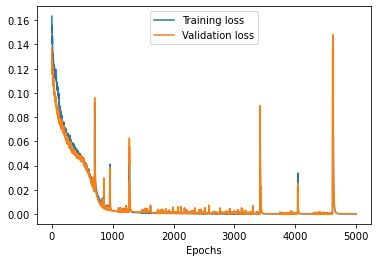

In [219]:
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel('Epochs')
plt.legend()
plt.savefig("../images/Burgers_loss.png")
plt.show()

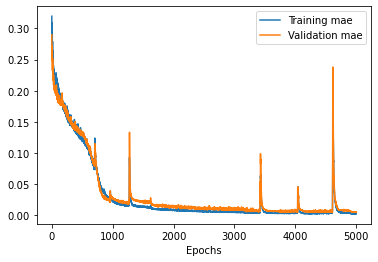

In [220]:
plt.plot(epochs, mae, label="Training mae")
plt.plot(epochs, val_mae, label="Validation mae")
plt.xlabel('Epochs')
plt.legend()
plt.savefig("../images/Burgers_mae.png")
plt.show()

Training of PINN doesn't seem very stable. Both MSE loss and MAE (error) have many spikes. What's the reason for it, and how can we get rid of them.

# Save and load model

In [ ]:
model_path =  "../models/Burgers.keras"  # Save model

In [ ]:
# model.save(model_path)

In [218]:
model = keras.models.load_model(model_path, custom_objects={'custom_loss': custom_loss})

# Inference

In [200]:
t_flat = T.reshape(-1, 1)
x_flat = X.reshape(-1, 1)

In [201]:
u_prediction = model.predict(np.hstack((x_flat, t_flat)))

800/800 [==============================] - 0s 346us/step


In [202]:
u_pred = u_prediction.reshape(100, 256)

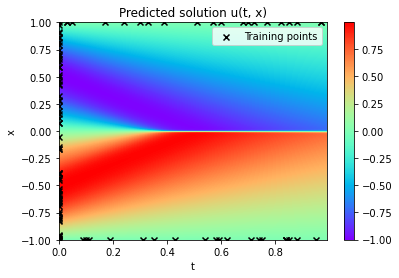

In [205]:
plt.imshow(u_pred.T, extent=(T.min(), T.max(), X.min(), X.max()),
          cmap="rainbow", aspect="auto", origin="lower")
plt.colorbar()
plt.scatter(X_u_train[:, 1], X_u_train[:, 0], marker='x', color='k',
            label="Training points")
plt.title("Predicted solution u(t, x)")
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

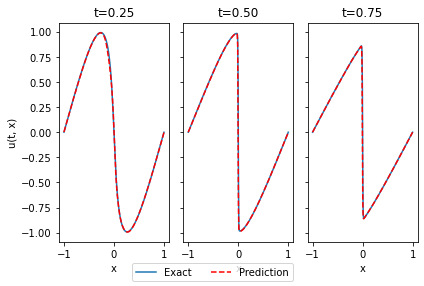

In [204]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
l1, = ax1.plot(X[24], Exact[24])
l2, = ax1.plot(X[24], u_pred[24], '--', c='r')

ax1.set_xlabel("x")
ax1.set_ylabel("u(t, x)")
ax1.set_title("t=0.25")

ax2.plot(X[49], Exact[49])
ax2.plot(X[49], u_pred[49], '--', c='r')

ax2.set_xlabel("x")
ax2.set_title("t=0.50")

ax3.plot(X[74], Exact[74])
ax3.plot(X[74], u_pred[74], '--', c='r')

ax3.set_xlabel("x")
ax3.set_title("t=0.75")

plt.tight_layout()
plt.figlegend((l1, l2), ("Exact", "Prediction"), loc = 'lower center', ncol=2, labelspacing=0.)
plt.show()


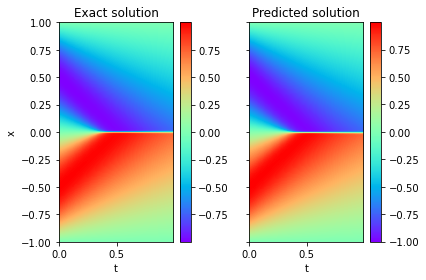

In [211]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
im1 = ax1.imshow(Exact.T, extent=(T.min(), T.max(), X.min(), X.max()),
          cmap="rainbow", aspect="auto", origin="lower")

ax1.set_title("Exact solution")
ax1.set_ylabel("x")
ax1.set_xlabel("t")
im2 = ax2.imshow(u_pred.T, extent=(T.min(), T.max(), X.min(), X.max()),
          cmap="rainbow", aspect="auto", origin="lower")
ax2.set_title("Predicted solution")
ax2.set_xlabel("t")
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.tight_layout()
plt.show()